In [30]:
import sys, os
import numpy as np

from utils import default_paths, roi_utils
from model_fitting import initialize_fitting 

import matplotlib.pyplot as plt
from matplotlib import cm

from plotting import load_fits, plot_utils, summary_plots
import copy
from utils import numpy_utils
from analyze_features import load_feature_stats


In [31]:
# Load everything

which_prf_grid = 5
models = initialize_fitting.get_prf_models(which_grid=which_prf_grid)
n_prfs = len(models)

which_partial_axes_negate = [1]
axes_to_do_partial = [0,2,3]
partial_discrim_names, partial_signed_names, _ = \
                load_feature_stats.load_partial_discrim_names(axes_to_do_partial, \
                                                              which_partial_axes_negate)


# Load CLIP results, get estimates of voxels semantic selectivity
subjects = np.arange(1,9)
n_subjects = len(subjects)
fitting_type = 'clip_RN50_best_layer_pca'
out = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type, n_from_end=0, \
                                  verbose=False) \
       for ss in subjects]
c_partial = np.concatenate([copy.deepcopy(out[si]['sem_partial_corrs']) for si in range(n_subjects)], axis=0)
n_sem_axes = c_partial.shape[1]
which_negate = [1]
c_partial[:,which_negate] *= (-1)

In [157]:
n_vox_each_subj = [out[si]['val_r2'].shape[0] for si in range(n_subjects)]
subject_inds = np.concatenate([si*np.ones((n_vox_each_subj[si],)) \
                                for si in range(n_subjects)], axis=0)

In [15]:
skip_inds = [4,5,7,11,12, 19,20, 22, 24]
roi_def = roi_utils.multi_subject_roi_def(subjects, skip_areas=skip_inds)
roi_names =roi_def.roi_names
n_rois = len(roi_names)

In [16]:

prf_pars = np.concatenate([out[si]['best_params'][0][:,0,:] for si in range(n_subjects)], axis=0)

voxel_ecc = np.round(np.sqrt(prf_pars[:,0]**2+prf_pars[:,1]**2)*8.4,2)
voxel_angle = np.round(np.mod(np.arctan2(prf_pars[:,1],prf_pars[:,0])*180/np.pi, 360),1)
voxel_size = np.round(prf_pars[:,2]*8.4,2)

voxel_ycoord = np.round(prf_pars[:,1]*8.4,2)
voxel_xcoord = np.round(prf_pars[:,0]*8.4,2)

parslist = [voxel_ecc, voxel_angle, voxel_size, voxel_xcoord, voxel_ycoord]
parnames = ['eccentricity (deg)', 'angle (deg)', 'size (deg)', \
            'Horizontal position (left-right)', 'Vertical position (down-up)']
parlims = [[-1,9], [-10,370], [-1, 10], [-9, 9], [-9, 9]]
particks = [[0,4,8], [0,90,180,270,360], [0,4,8], [-5,0,5], [-5,0,5]]


In [66]:
ecc_vals = np.unique(voxel_ecc)
ecc_cutoff = ecc_vals[4]+(ecc_vals[5] - ecc_vals[4])/2
size_vals = np.unique(voxel_size)
size_cutoff = size_vals[5]+(size_vals[6] - size_vals[5])/2
par_cutoffs = [ecc_cutoff, 180, size_cutoff,  0, 0]
par_level_names = [['foveal','peripheral'], \
                   ['upper vis field', 'lower vis field'], \
                   ['small pRF', 'large pRF'], \
                   ['left vis field', 'right vis field'], \
                   ['lower vis field', 'upper vis field']]

In [164]:
import scipy.stats

mean_corr_bins = np.zeros((n_subjects, n_sem_axes, n_rois, len(parslist),2))
std_corr_bins = np.zeros((n_subjects, n_sem_axes, n_rois, len(parslist),2))
nsamp_corr_bins = np.zeros((n_subjects, n_rois, len(parslist), 2))

tvals = np.zeros((n_subjects, n_sem_axes, n_rois, len(parslist)))
pvals = np.zeros((n_subjects, n_sem_axes, n_rois, len(parslist)))

r2_cutoff = 0.10

for rr in range(n_rois):

    for ss in range(n_subjects):

        inds2use = out[ss]['val_r2'][:,0] > r2_cutoff
        voxel_inds_use = roi_def.ss_roi_defs[ss].get_indices(rr) & inds2use

        for pp in range(len(parslist)):

            vals = parslist[pp][subject_inds==ss]
            inds1 = (vals<par_cutoffs[pp]) & voxel_inds_use
            inds2 = (vals>par_cutoffs[pp]) & voxel_inds_use
            if np.sum(inds1)==0 or np.sum(inds2)==0:
                mean_corr_bins[ss,:,rr,pp,:] = np.nan
                std_corr_bins[ss,:,rr,pp,:] = np.nan
                tvals[ss,:,rr,pp] = np.nan
                pvals[ss,:,rr,pp] = np.nan
                continue
            nsamp_corr_bins[ss,rr,pp,0] = np.sum(inds1)
            nsamp_corr_bins[ss,rr,pp,1] = np.sum(inds2)


            for aa in range(n_sem_axes):
                cvals = c_partial[:,aa][subject_inds==ss]
                mean_corr_bins[ss,aa,rr,pp,0] = np.mean(cvals[inds1])
                mean_corr_bins[ss,aa,rr,pp,1] = np.mean(cvals[inds2])
                std_corr_bins[ss,aa,rr,pp,0] = np.std(cvals[inds1])
                std_corr_bins[ss,aa,rr,pp,1] = np.std(cvals[inds2])

                test = scipy.stats.ttest_ind(cvals[inds1], cvals[inds2], \
                                                        equal_var=False)
                tvals[ss,aa,rr,pp] = test.statistic
                pvals[ss,aa,rr,pp] = test.pvalue

           

In [131]:
import statsmodels.stats.multitest
orig_shape = pvals.shape
p_thresh, p_corrected = statsmodels.stats.multitest.fdrcorrection(pvals.ravel(), alpha=0.01)
p_thresh = np.reshape(p_thresh, orig_shape)
p_corrected = np.reshape(p_corrected, orig_shape)

In [179]:
# for pp in range(len(parslist)):
#     print('pRF %s'%(parnames[pp]))
#     for aa in range(n_sem_axes):
#         print('    %s'%partial_signed_names[aa])
#         for rr in range(n_rois):
#             if p_thresh[aa,rr,pp]:
#                 print('        %s'%roi_names[rr])

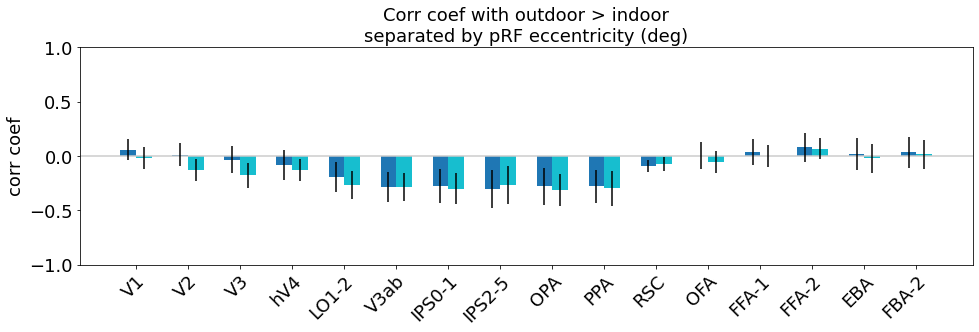

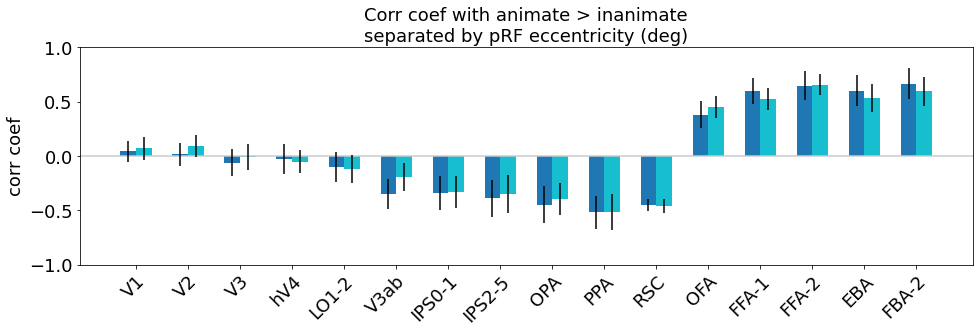

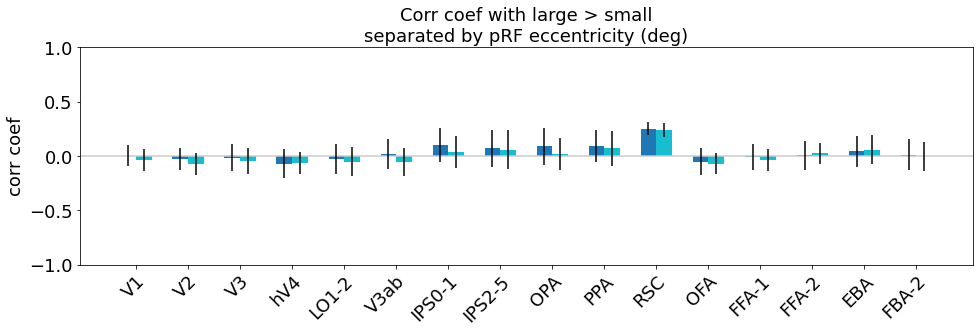

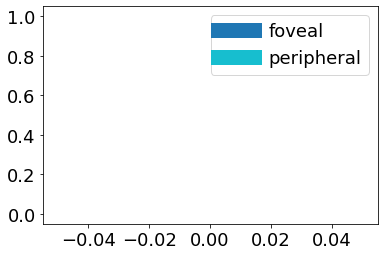

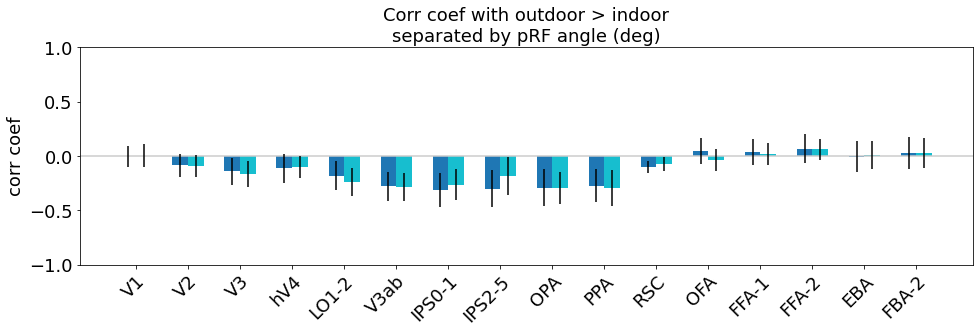

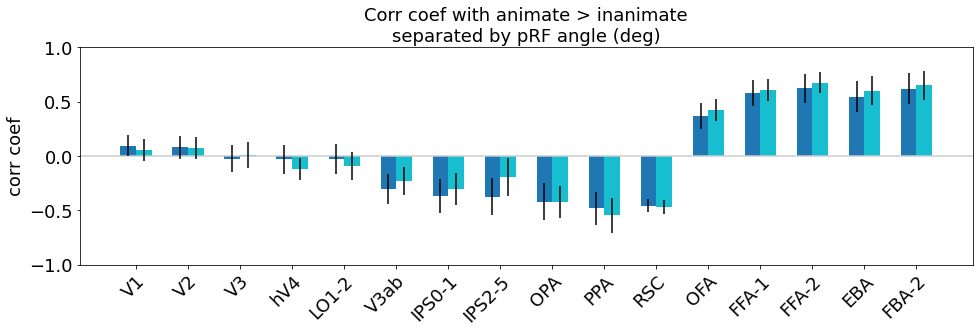

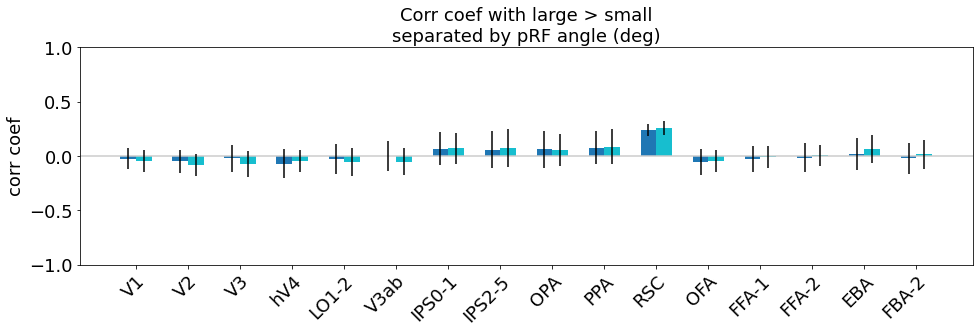

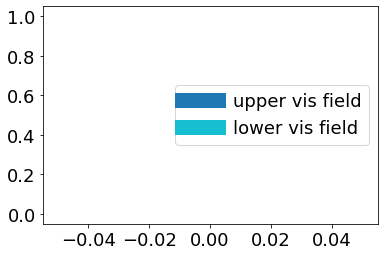

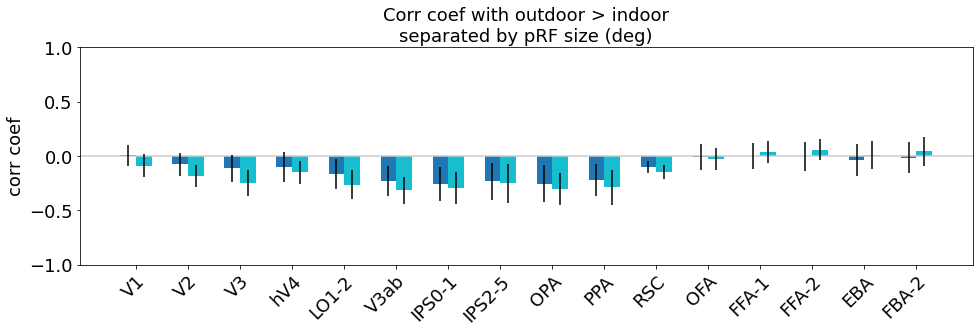

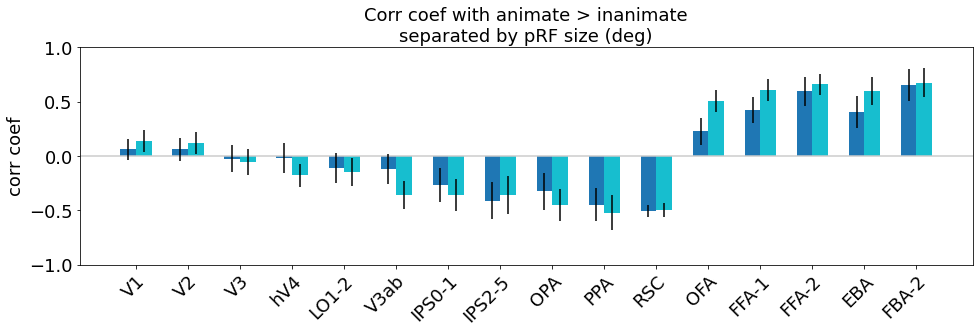

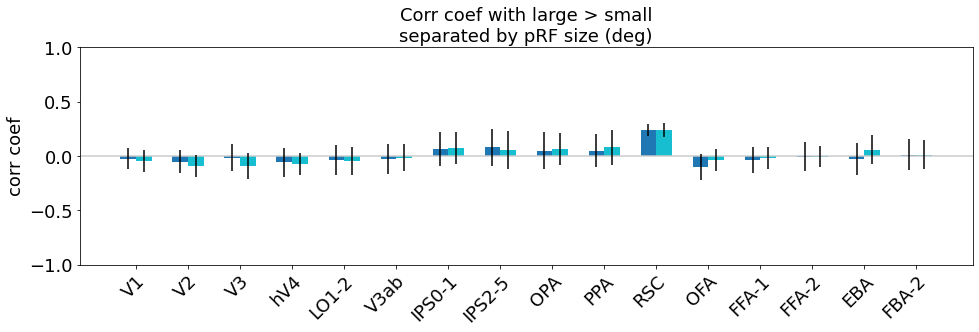

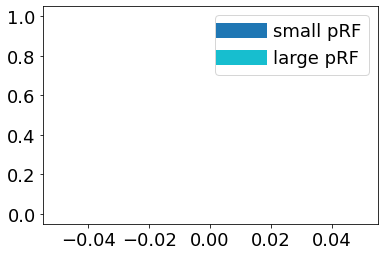

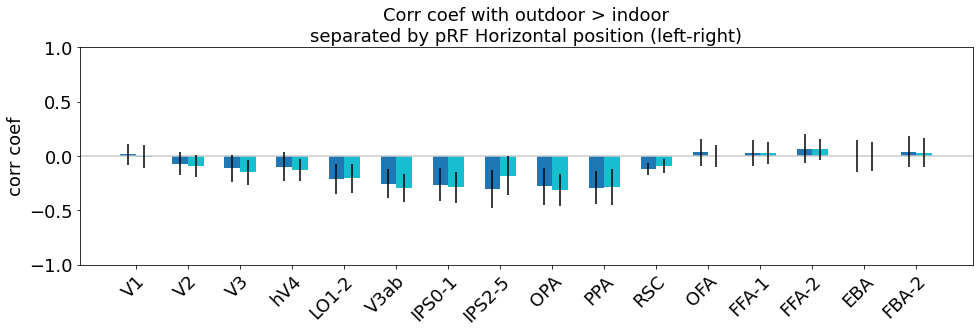

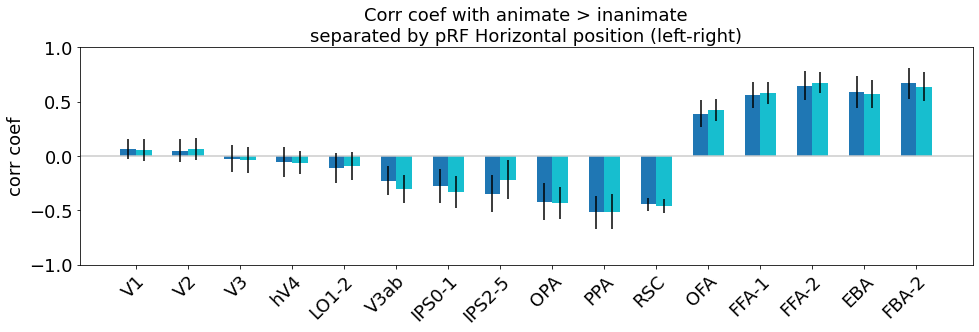

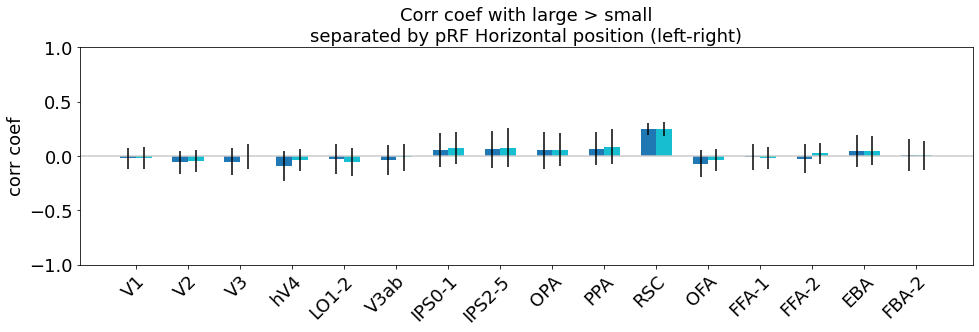

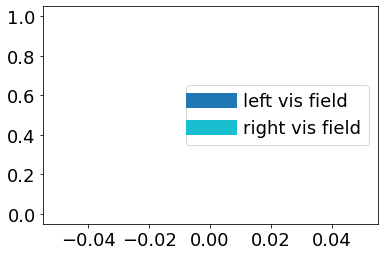

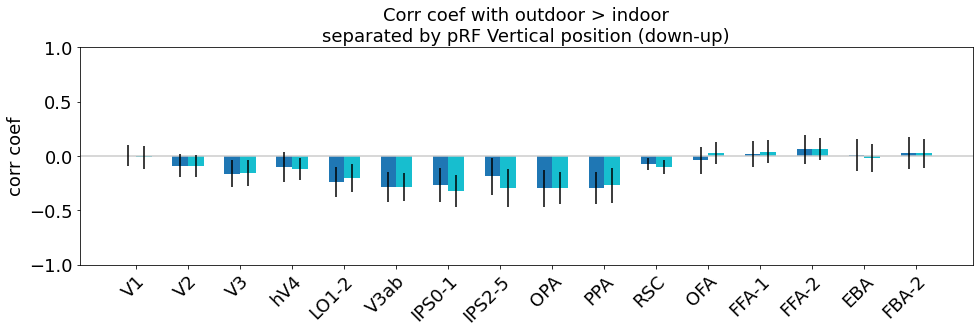

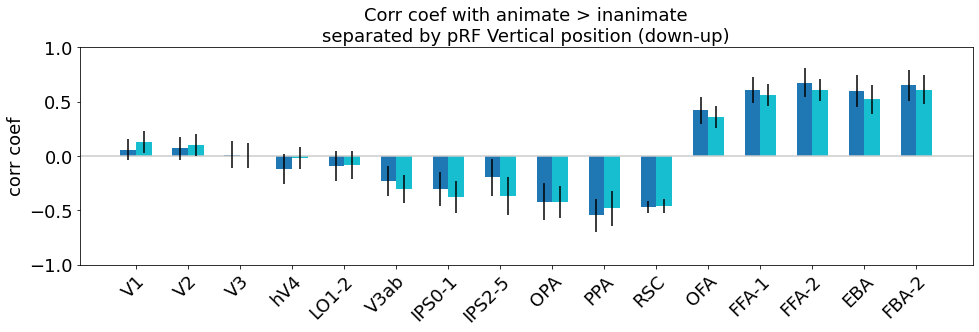

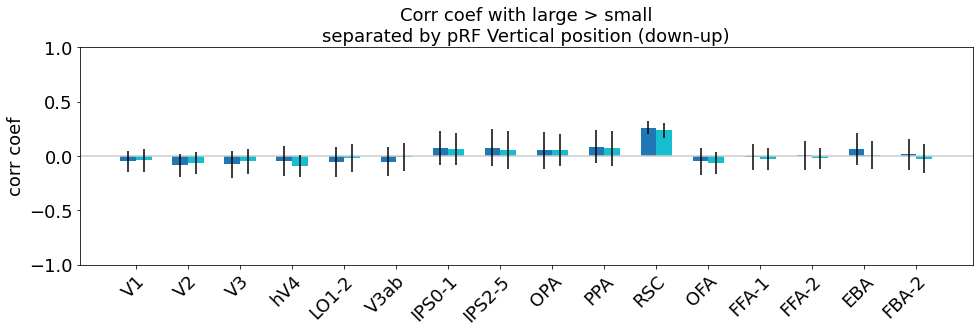

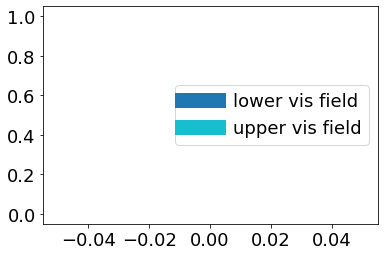

In [178]:
for pp in range(len(parslist)):

    for aa in range(n_sem_axes):

        mean_vals = np.nanmean(mean_corr_bins[:,aa,:,pp,:], axis=0)
        sem_vals = np.nanstd(mean_corr_bins[:,aa,:,pp,:], axis=0)/np.sqrt(n_subjects)
#         std_vals = std_corr_bins[:,aa,:,pp,:]

        if aa==(n_sem_axes-1):
            legend_separate=True
        else:
            legend_separate=False
        title = 'Corr coef with %s\nseparated by pRF %s'%(partial_signed_names[aa], parnames[pp])

        fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=std_vals, \
                        colors=None, space=0.20, \
                        xticklabels=roi_names, ylabel='corr coef', \
                        ylim=[-1,1], title=title, horizontal_line_pos=0,\
                        legend_labels=par_level_names[pp], \
                        legend_overlaid=False, legend_separate=legend_separate, \
                        fig_size=(16,4))

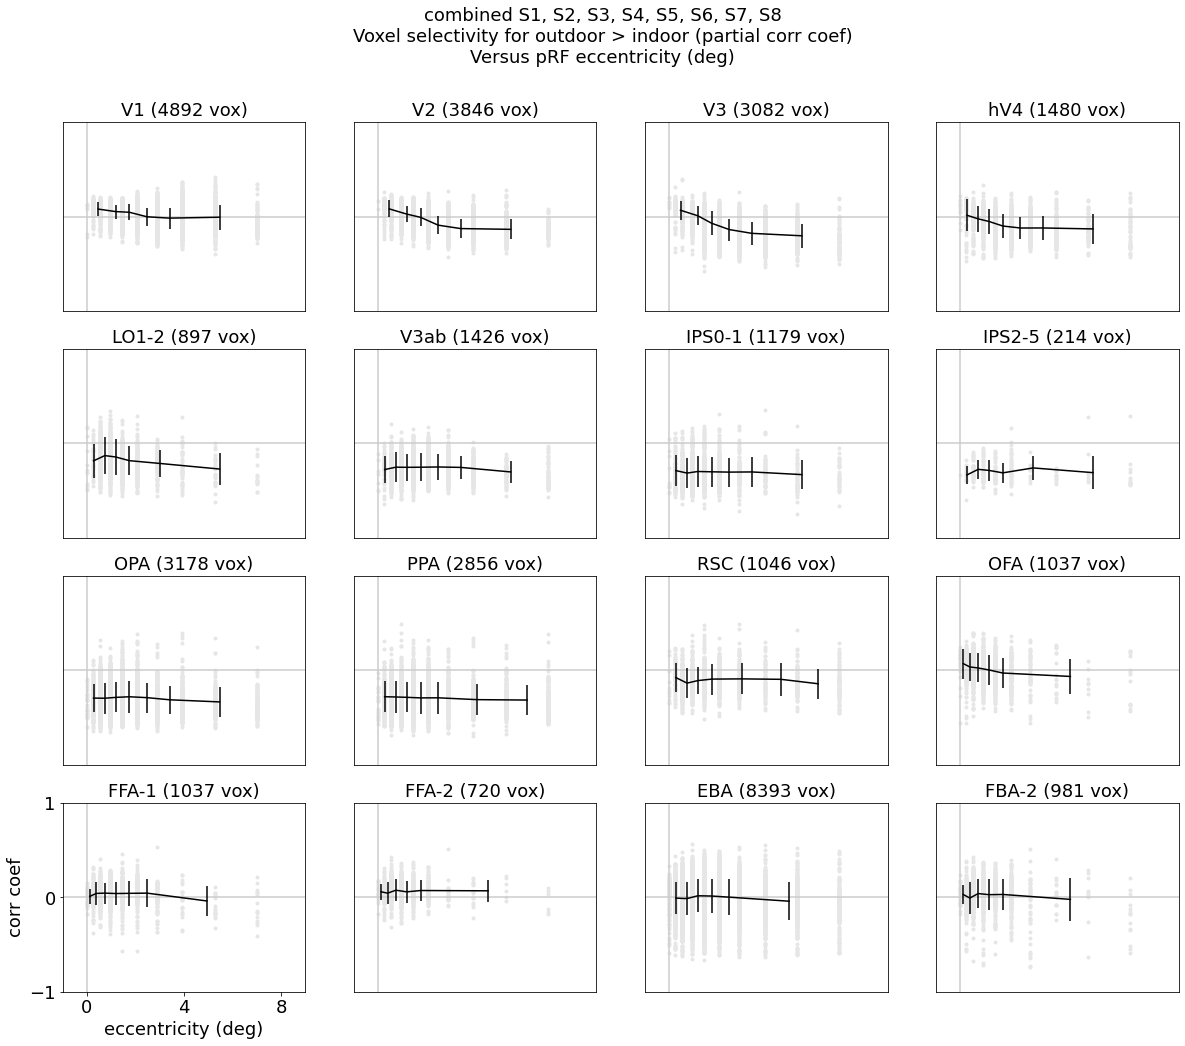

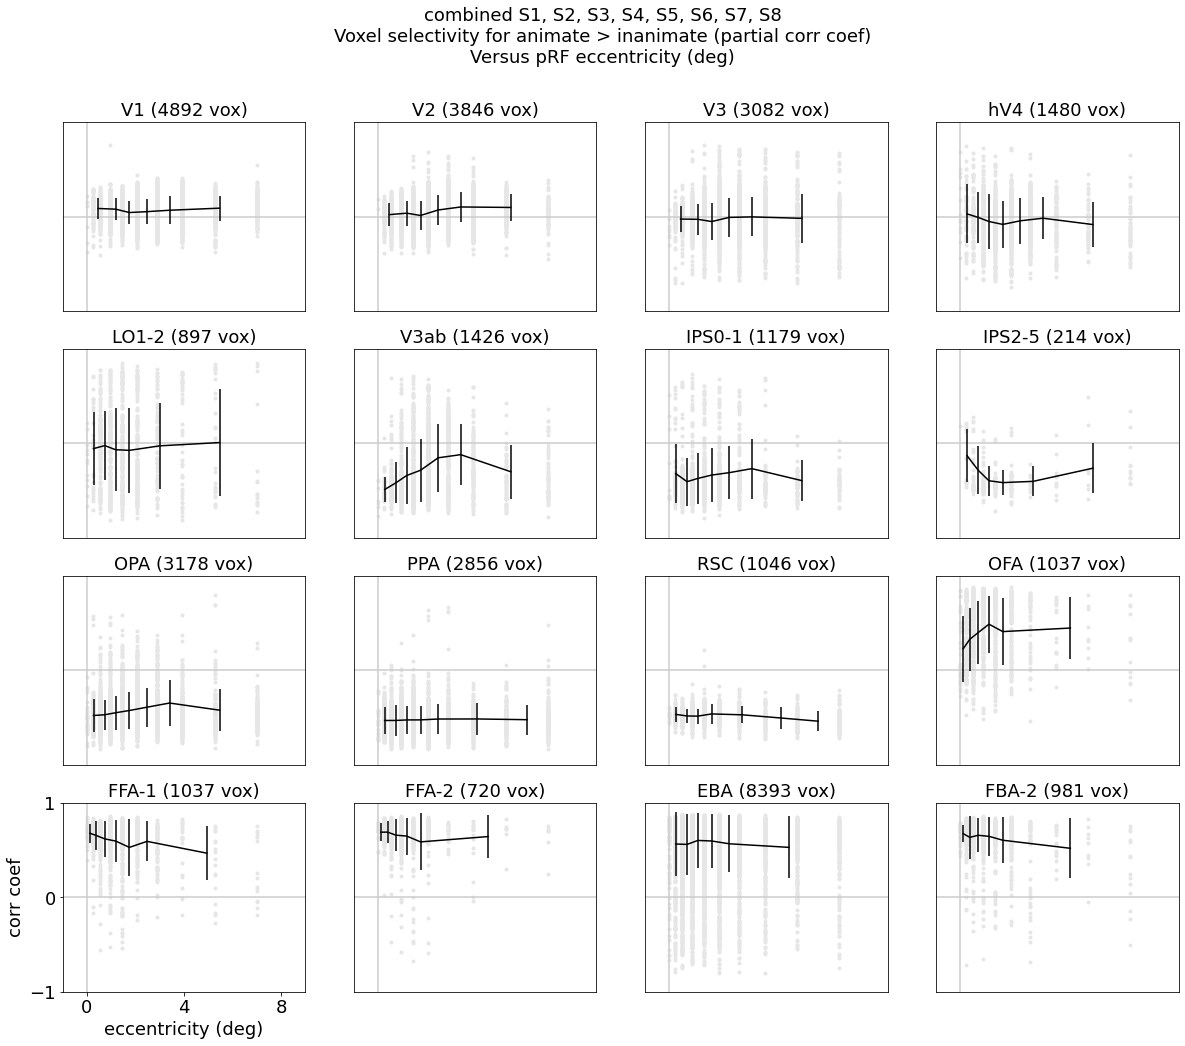

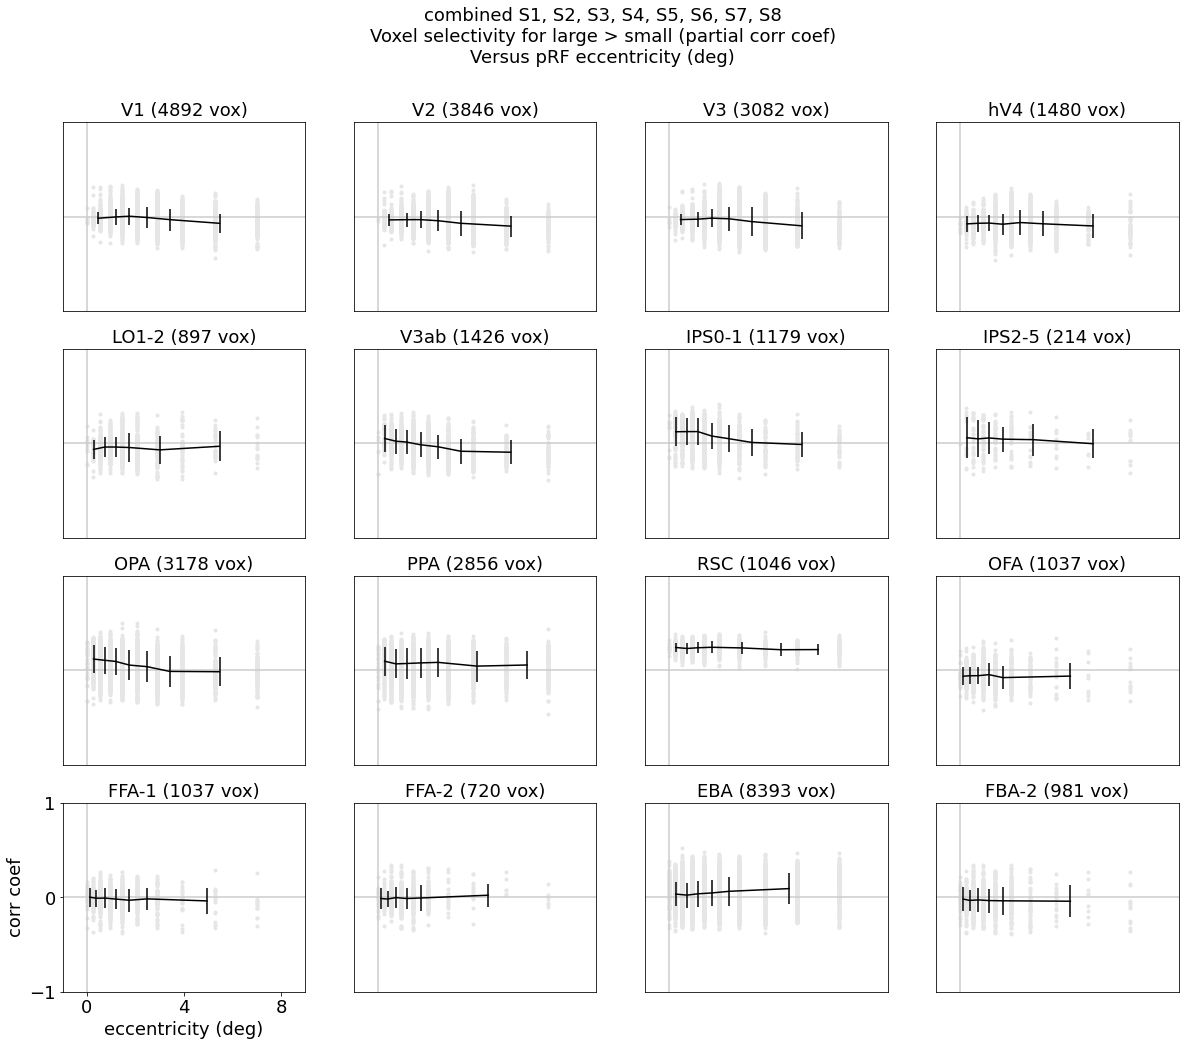

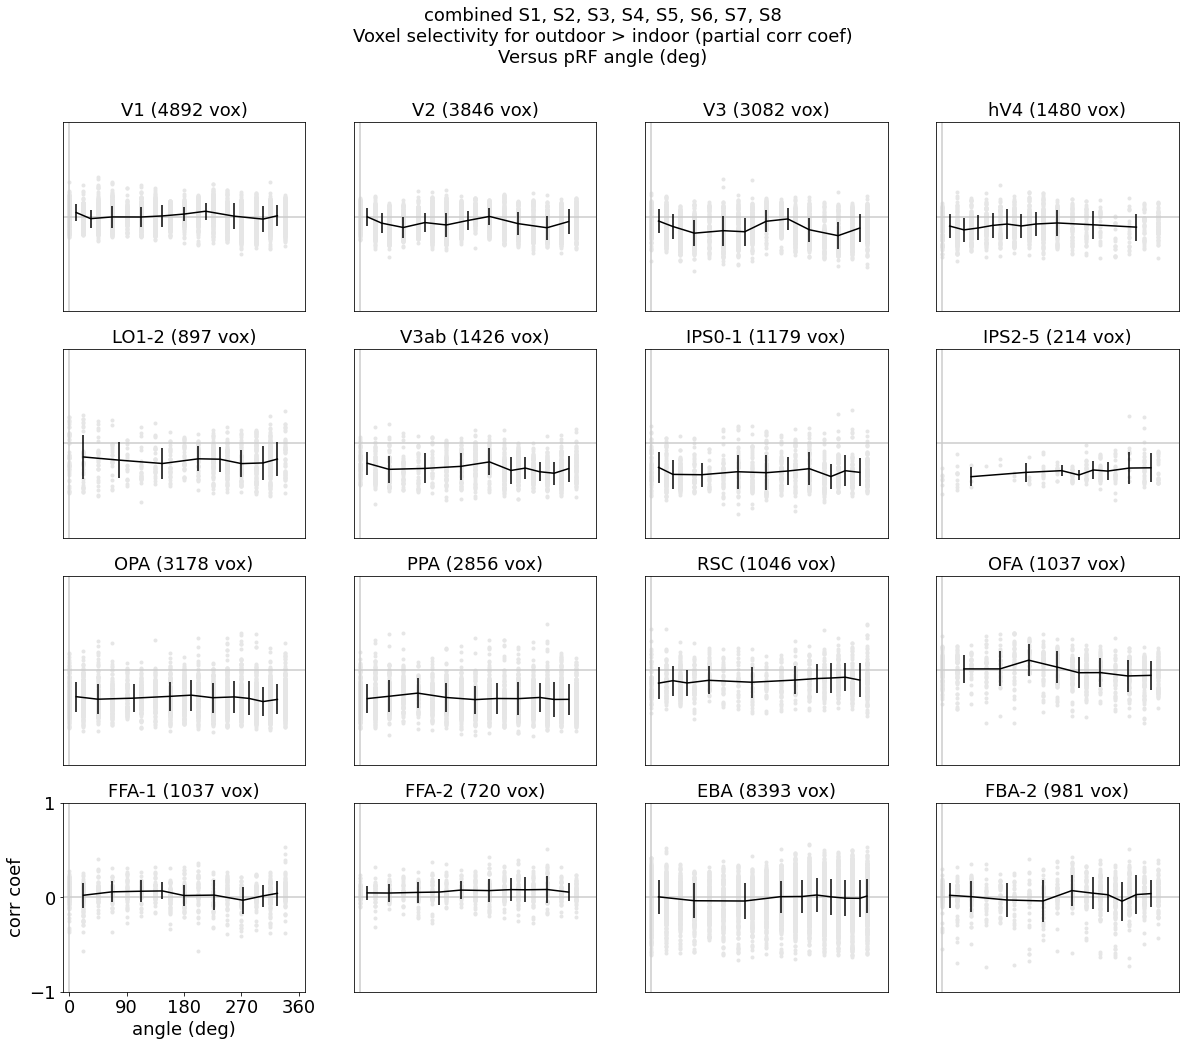

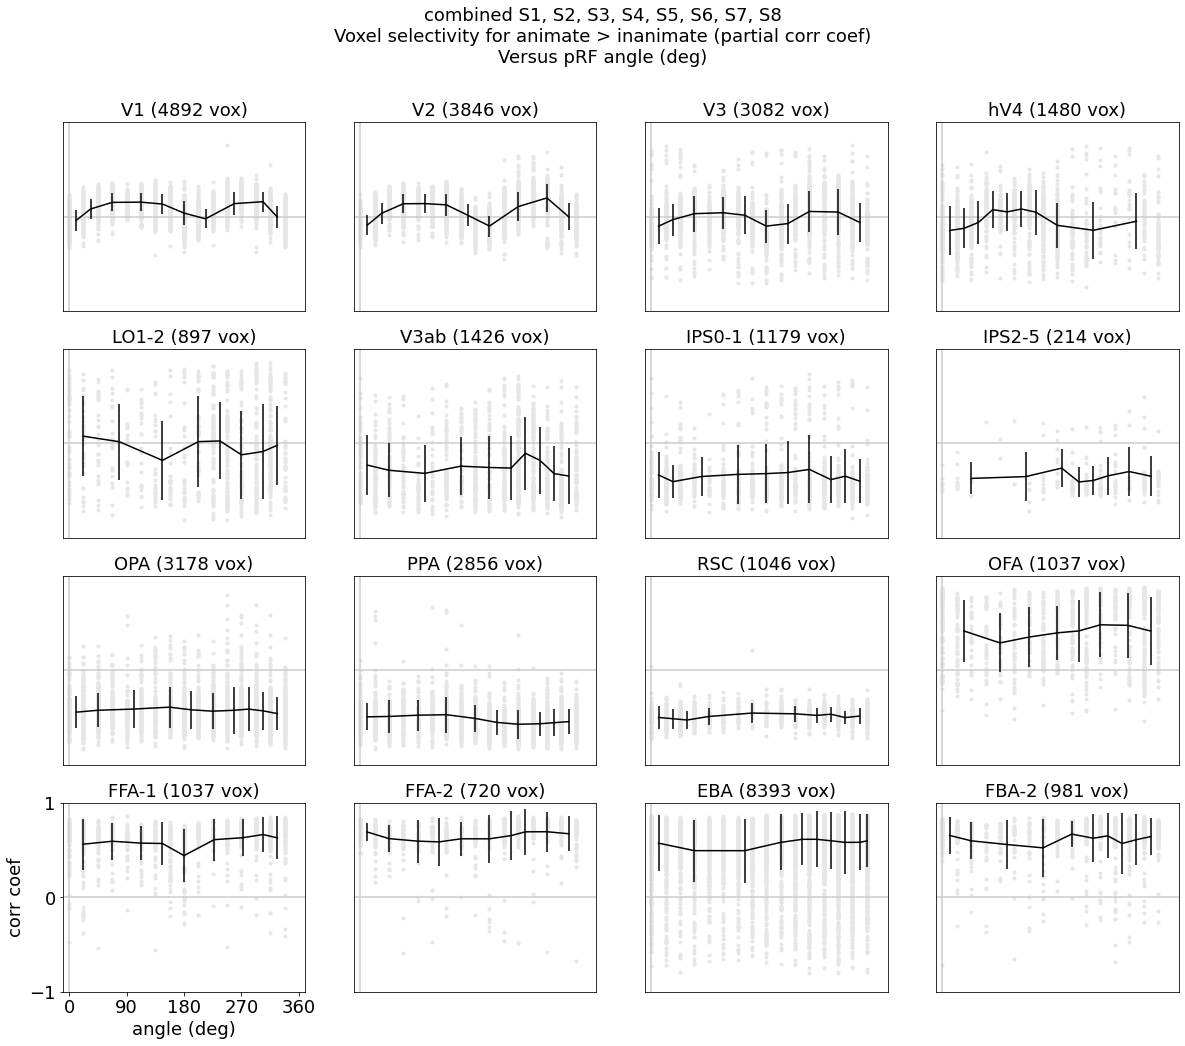

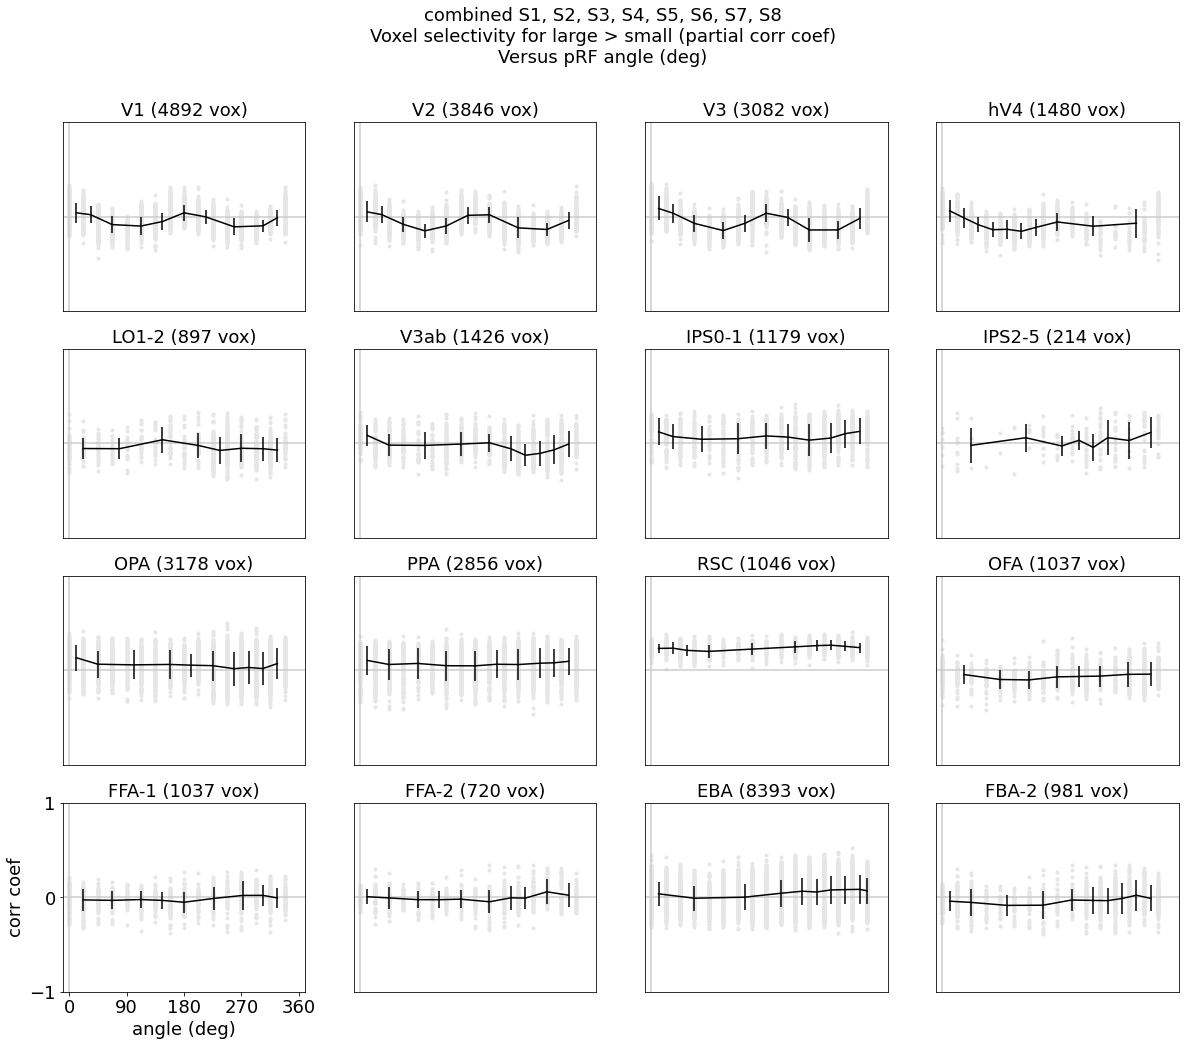

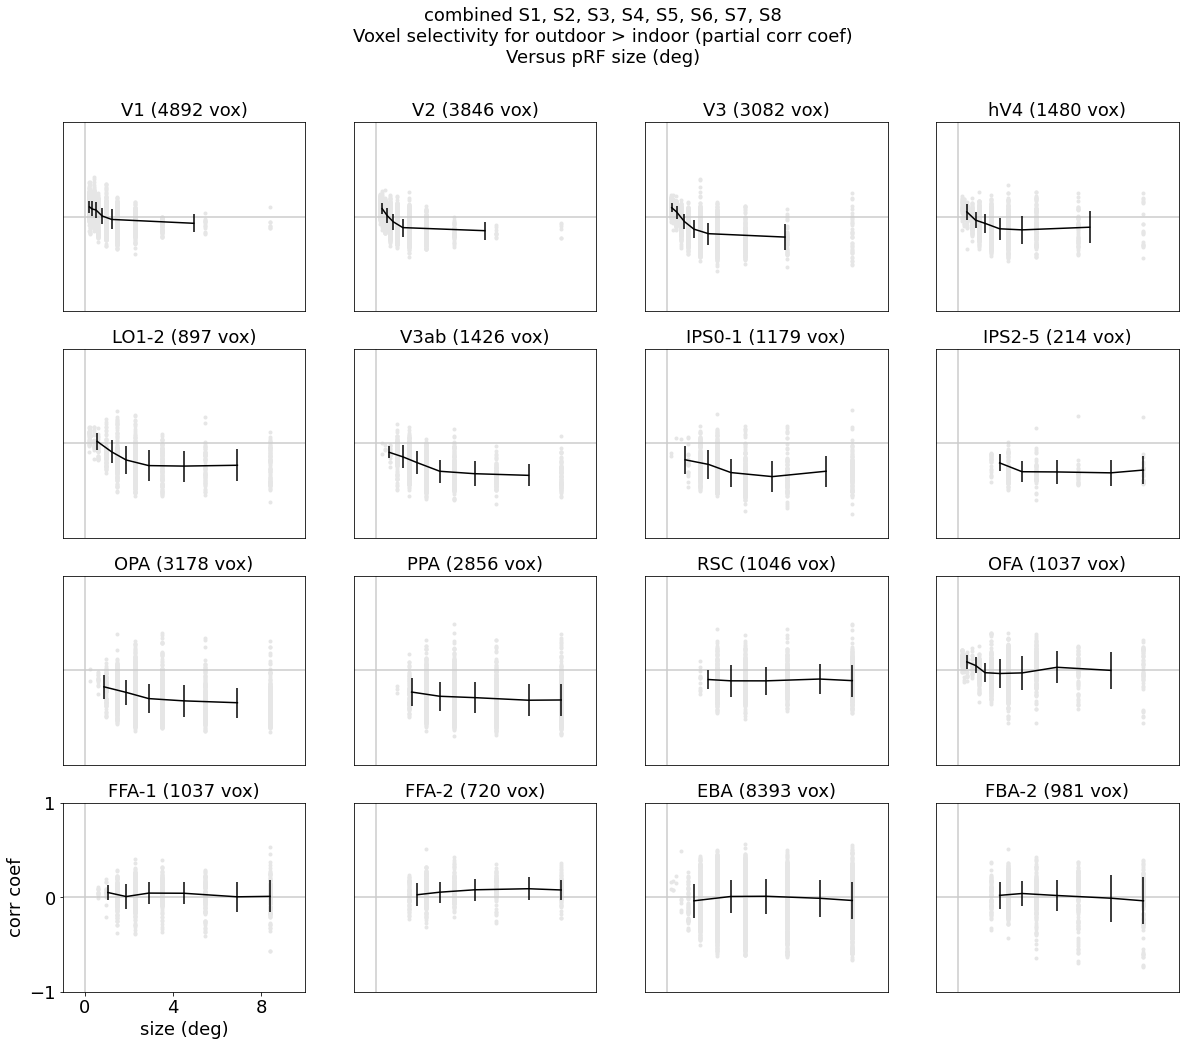

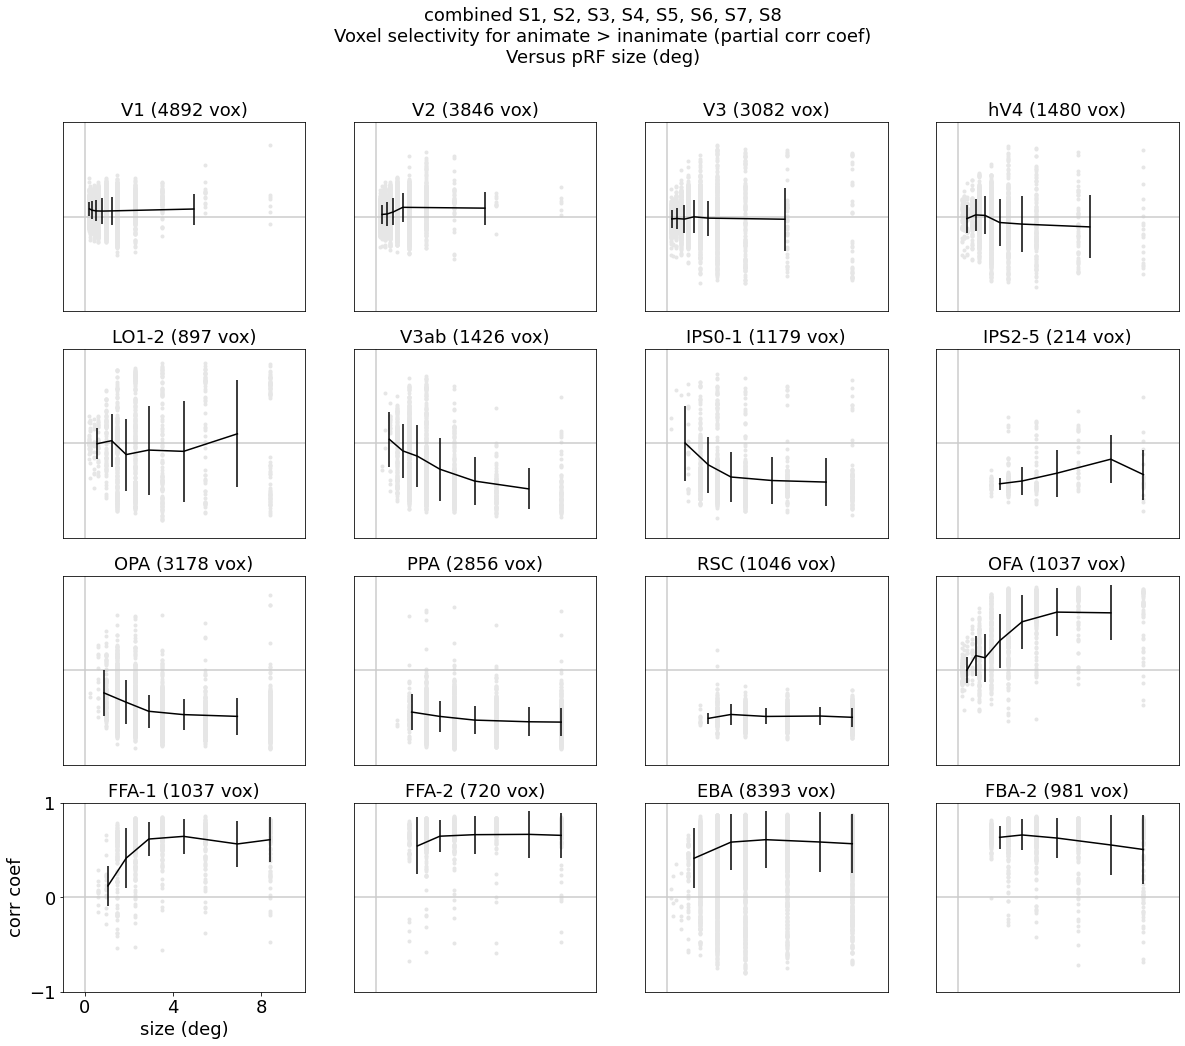

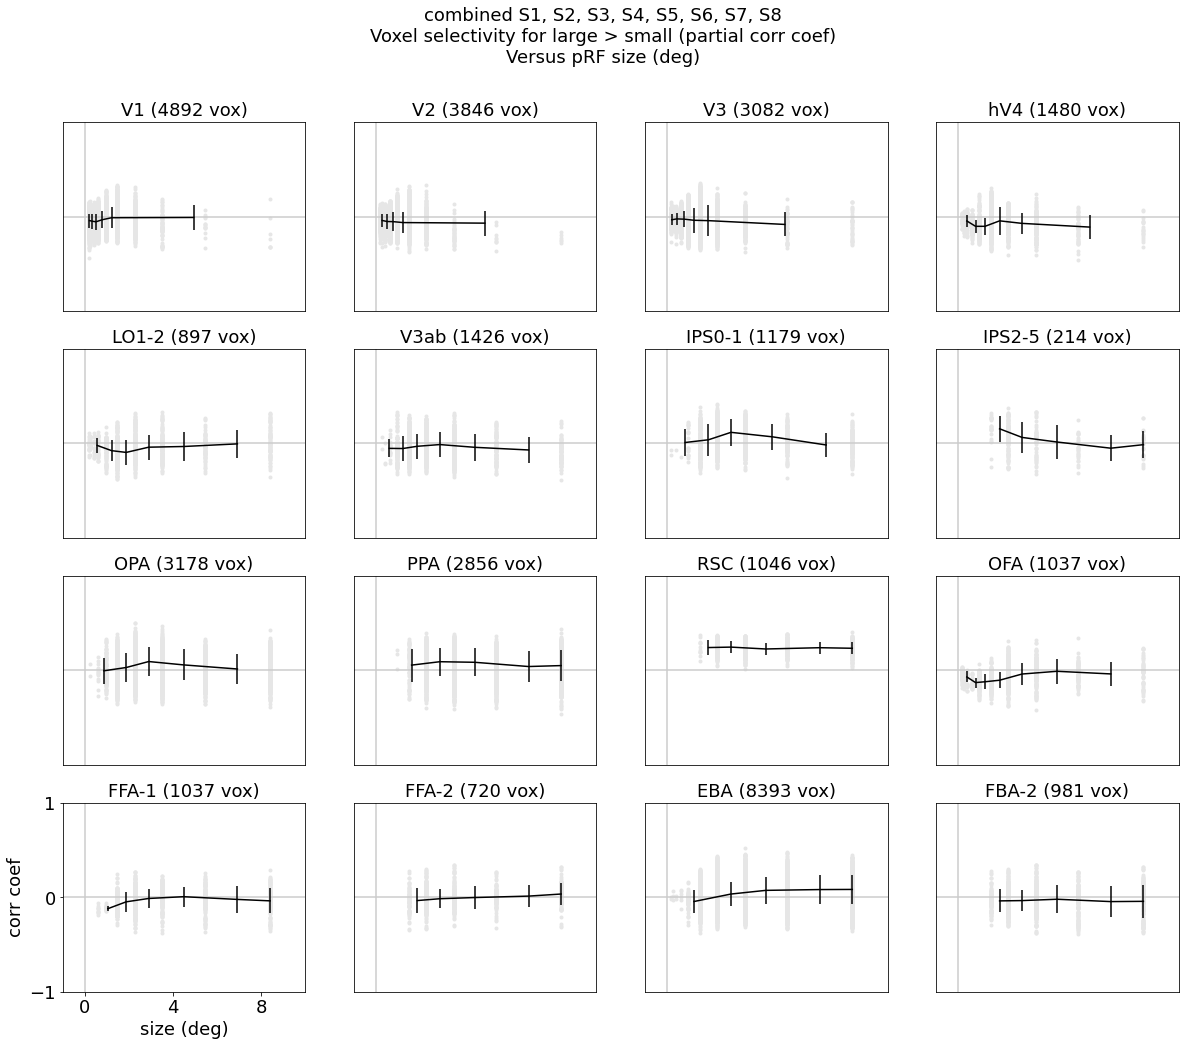

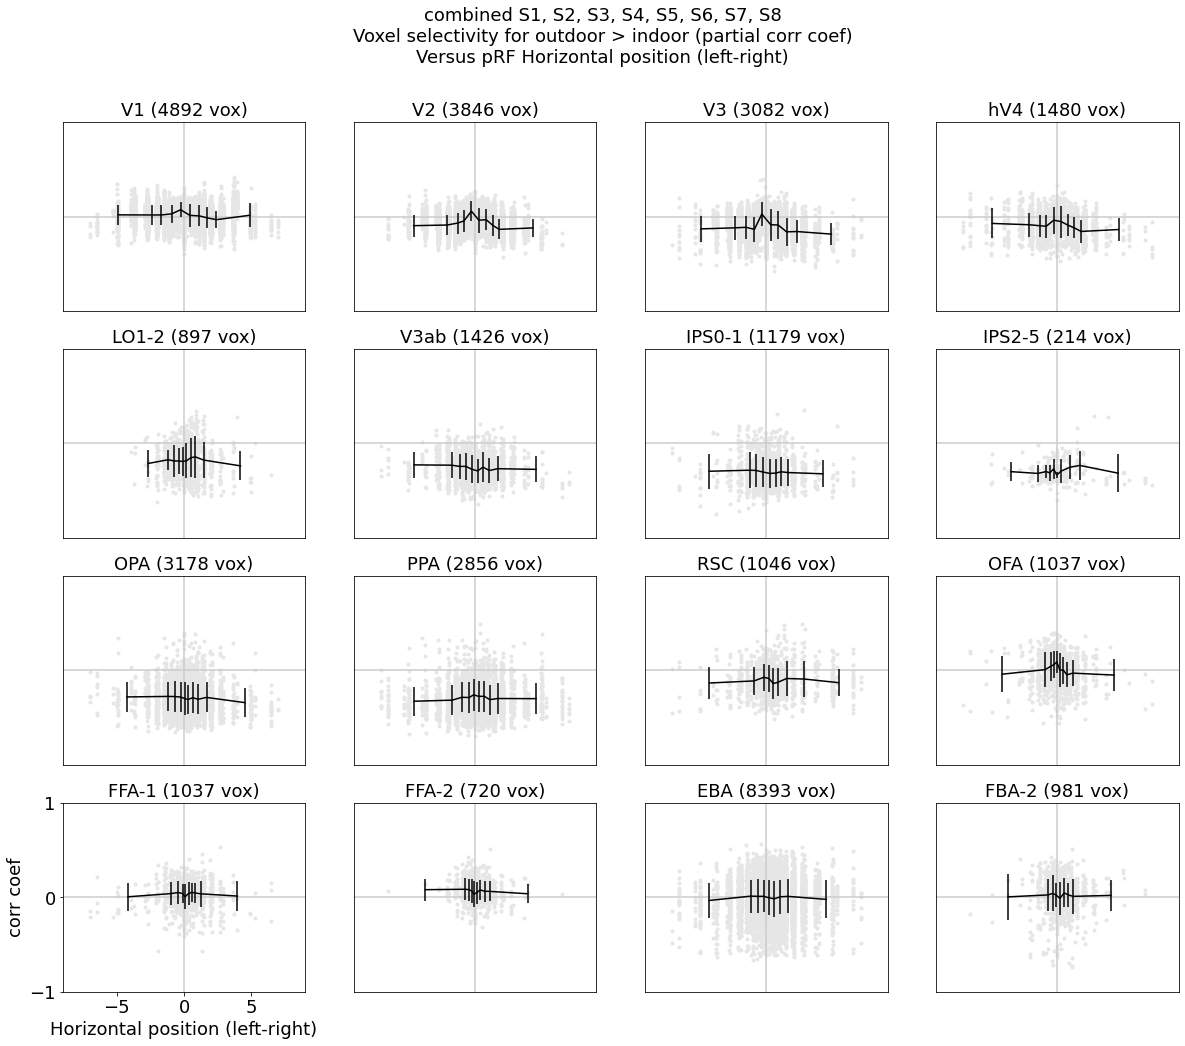

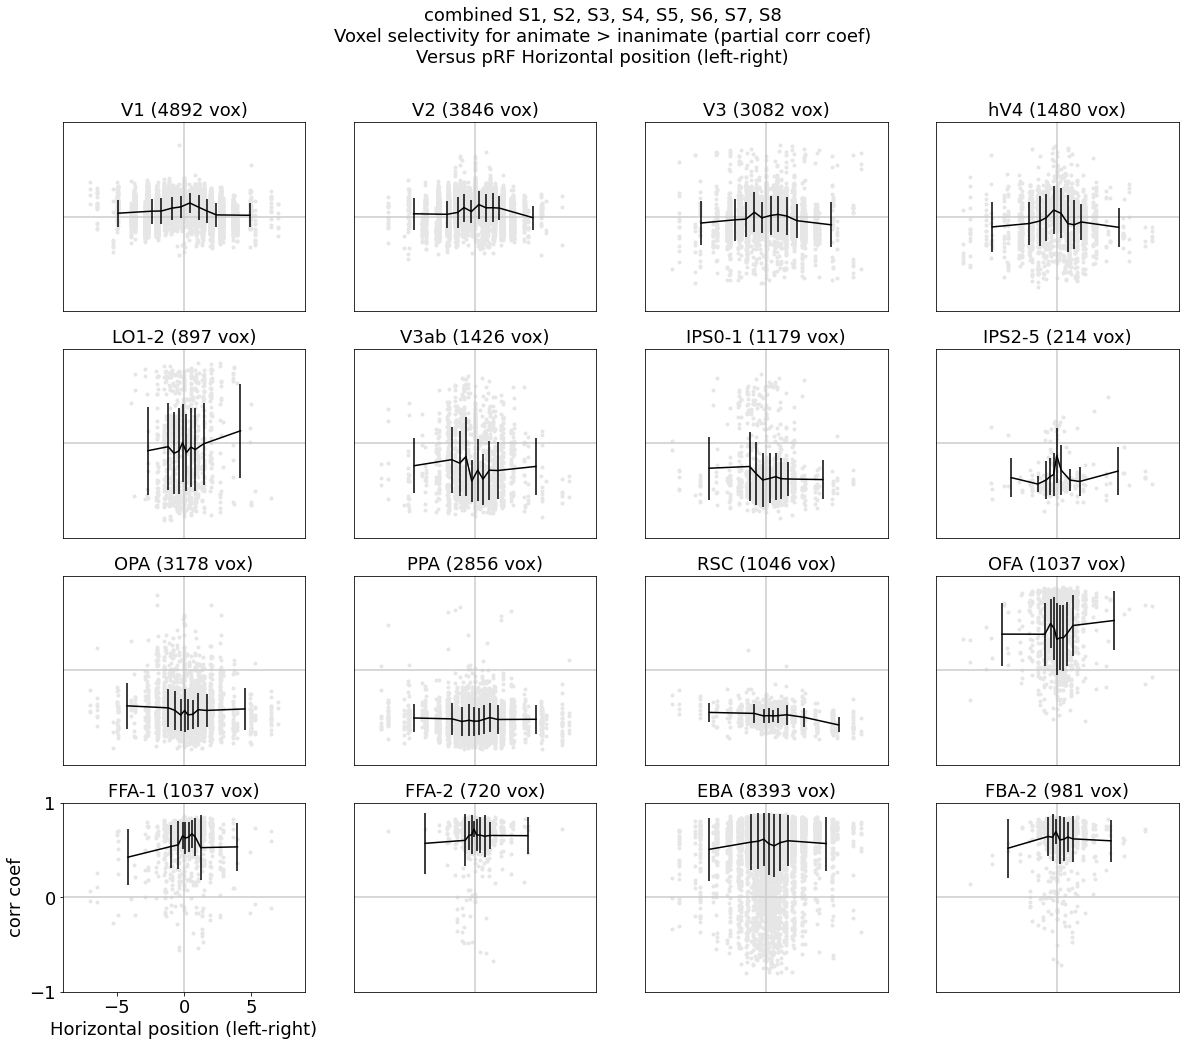

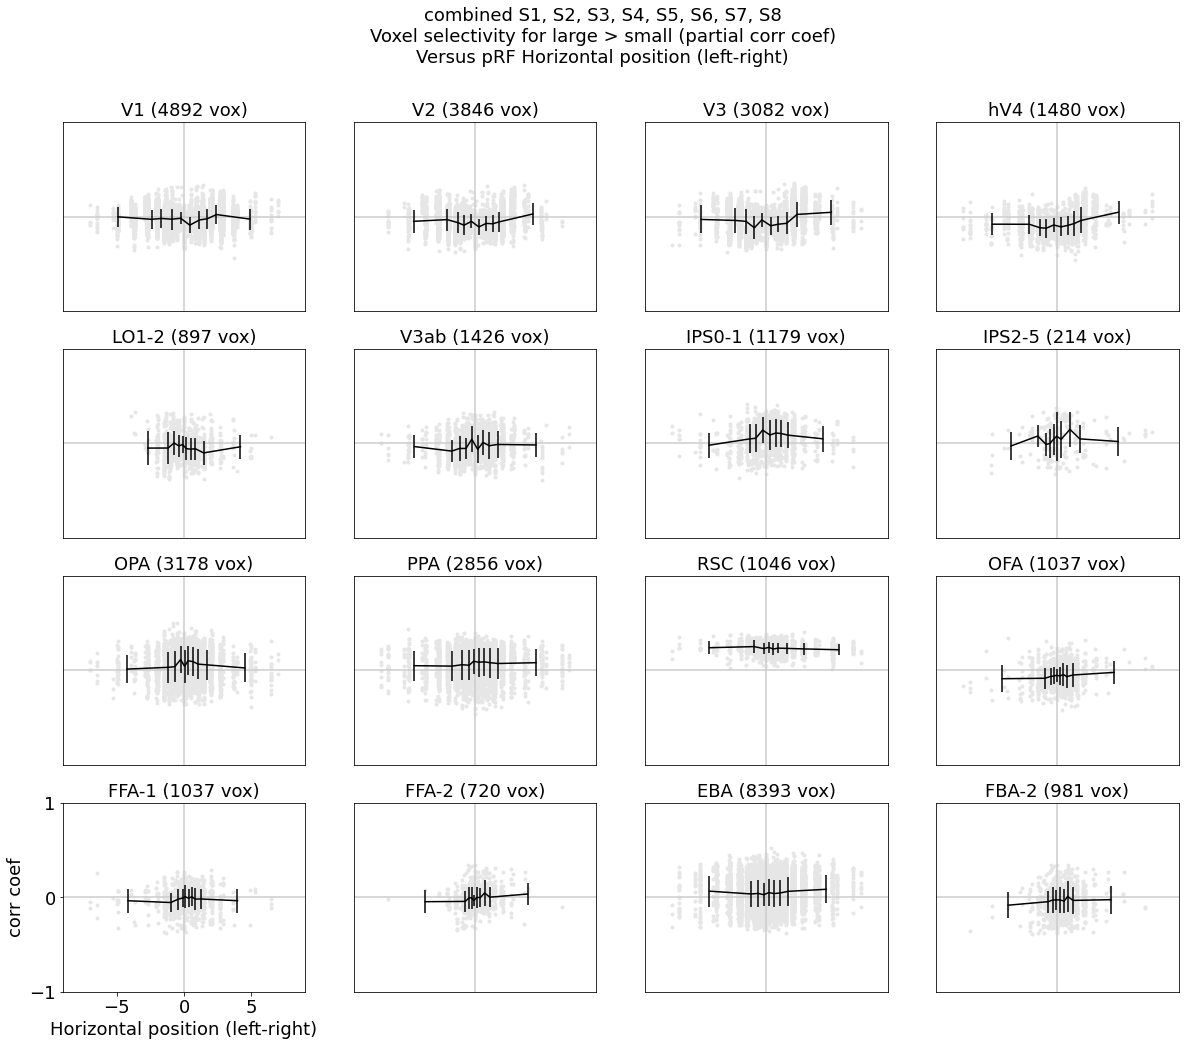

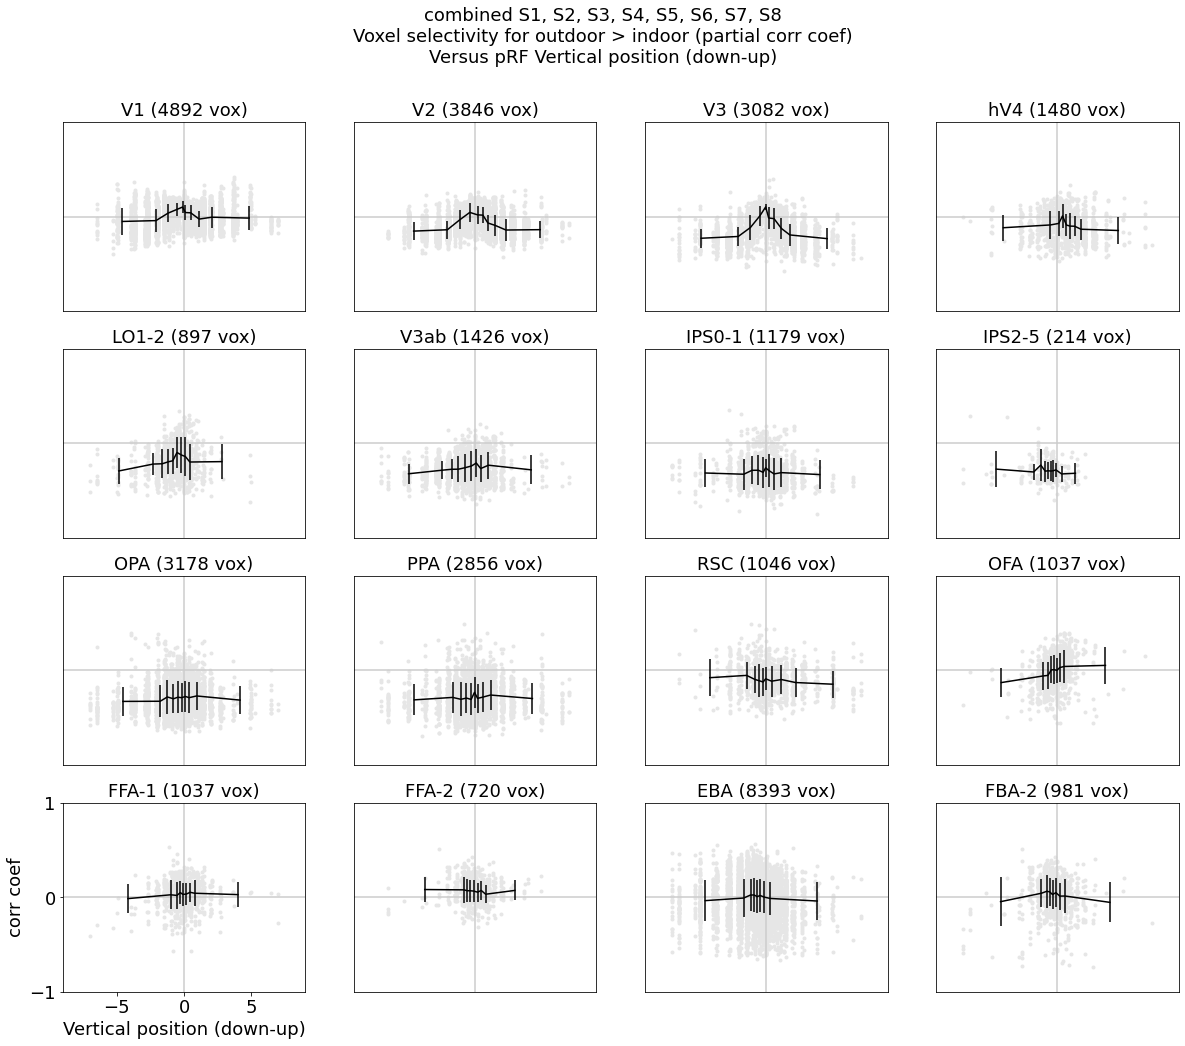

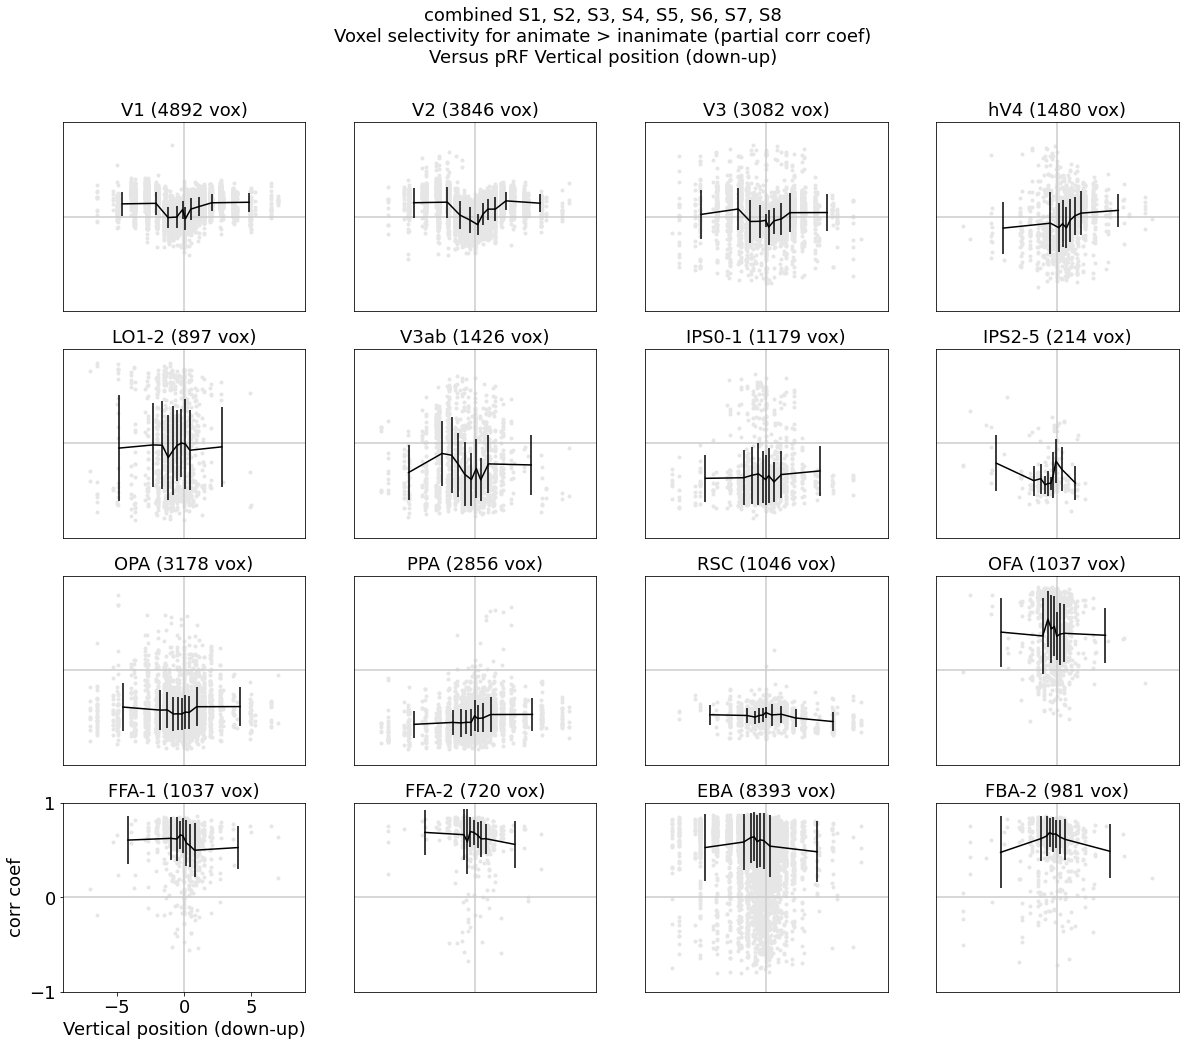

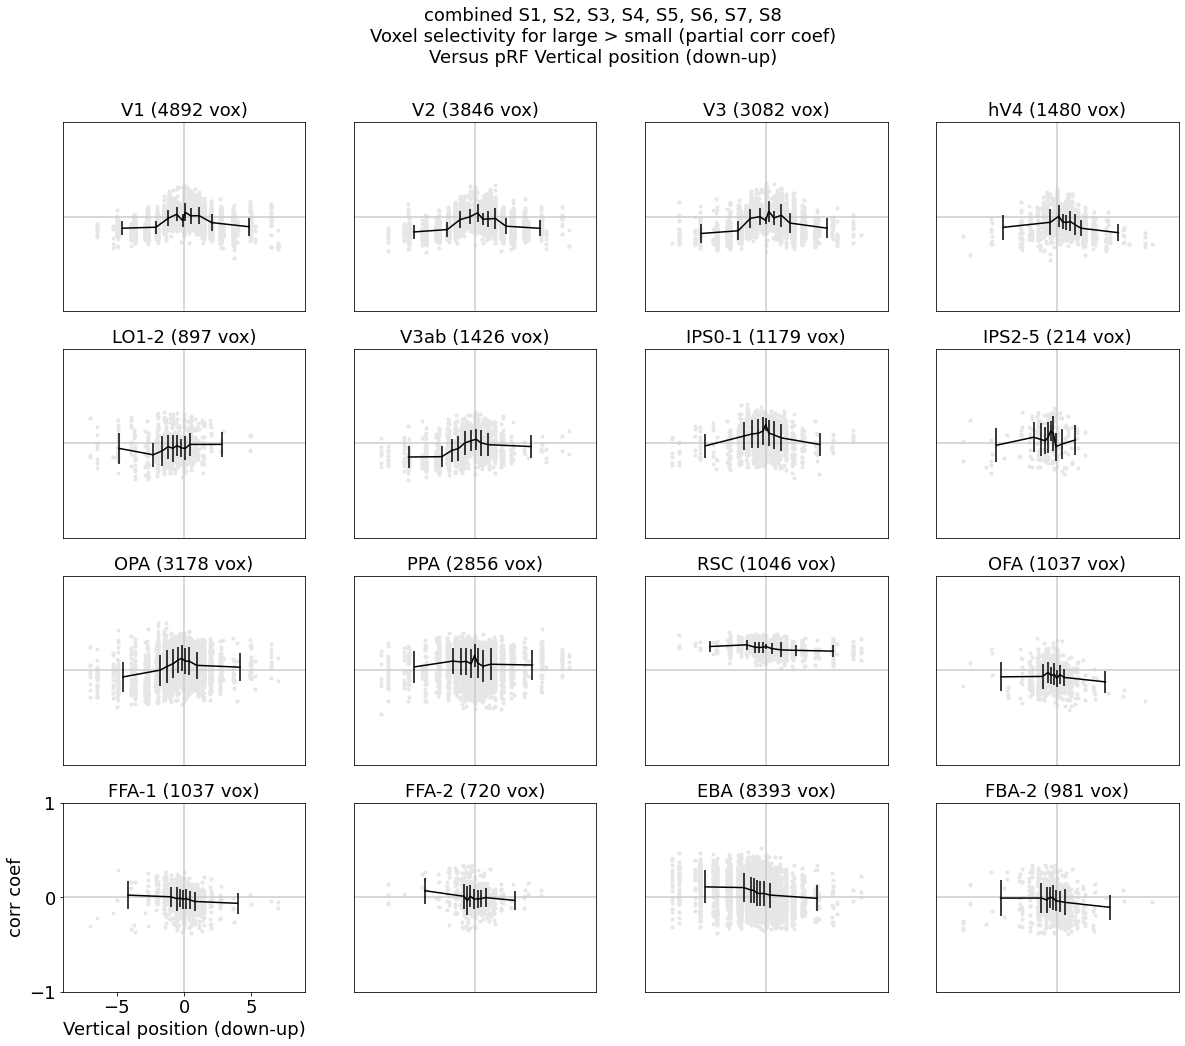

In [180]:

plot_utils.set_all_font_sizes(fs = 18)
npx = int(np.ceil(np.sqrt(n_rois)))
npy = int(np.ceil(n_rois/npx))

dd2plot = [0,1,2];
# dd2plot = [0]

n_bins=10;
linear_bins=False

r2_cutoff = 0.10
val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)
inds2use = val_r2 > r2_cutoff

# pp2plot = [3]

# for pp in pp2plot:
#     pars = parslist[pp]
for pp, pars in enumerate(parslist):

    for dd in dd2plot:

        val1 = pars
        val2 = copy.deepcopy(c_partial[:,dd])

        name = partial_signed_names[dd]
        
        pi=0
        plt.figure(figsize=(20,16))

        for rr in range(n_rois):

            inds_this_roi = roi_def.get_indices(rr) & inds2use
            x_vals=val1[inds_this_roi];
            y_vals=val2[inds_this_roi]

            pi+=1
            plt.subplot(npx,npy,pi)

            ptcolor=np.array([[0.9, 0.9, 0.9]])
    #         ptcolor=None
            plt.plot(x_vals,y_vals,'.',color=ptcolor)
            xbinned, ybinned, ystd = numpy_utils.bin_ydata_by_xdata(x_vals, y_vals, n_bins=n_bins, \
                                                linear_bins=linear_bins, return_std=True)    
            plt.errorbar(xbinned, ybinned, ystd, color='k',zorder=10)

#             plt.xlim([-1,10])
            plt.xlim(parlims[pp])
            plt.ylim([-1,1])

            plt.axhline(0,color=[0.8, 0.8, 0.8])
            plt.axvline(0,color=[0.8, 0.8, 0.8])
            plt.title('%s (%d vox)'%(roi_names[rr], np.sum(inds_this_roi)))

            if pi==(n_rois-3):
                plt.xlabel(parnames[pp])
                plt.ylabel('corr coef')
                plt.xticks(particks[pp])
                plt.yticks([-1,0,1])
            else:
                plt.xticks([])
                plt.yticks([])

        plt.suptitle('%s\nVoxel selectivity for %s (partial corr coef)\nVersus pRF %s'\
                                       %(summary_plots.get_substr(out), name, parnames[pp]))


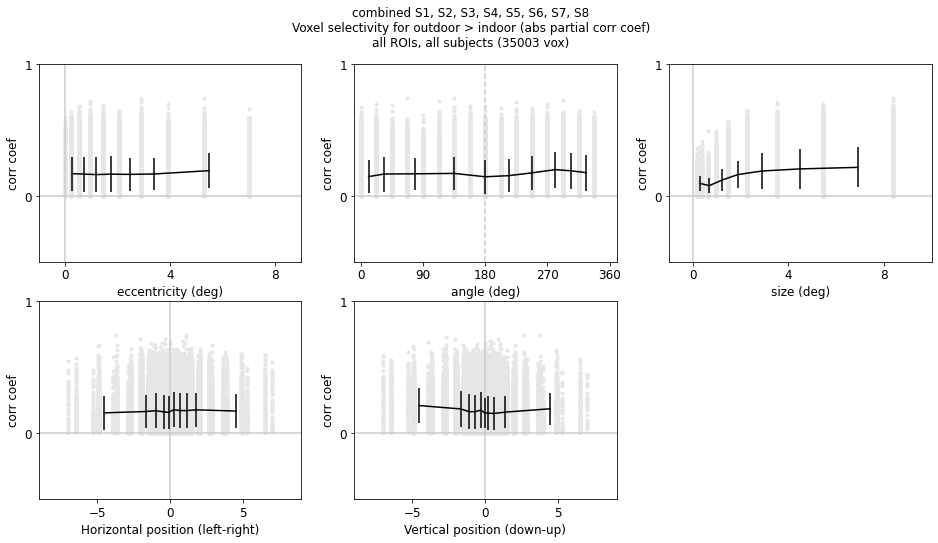

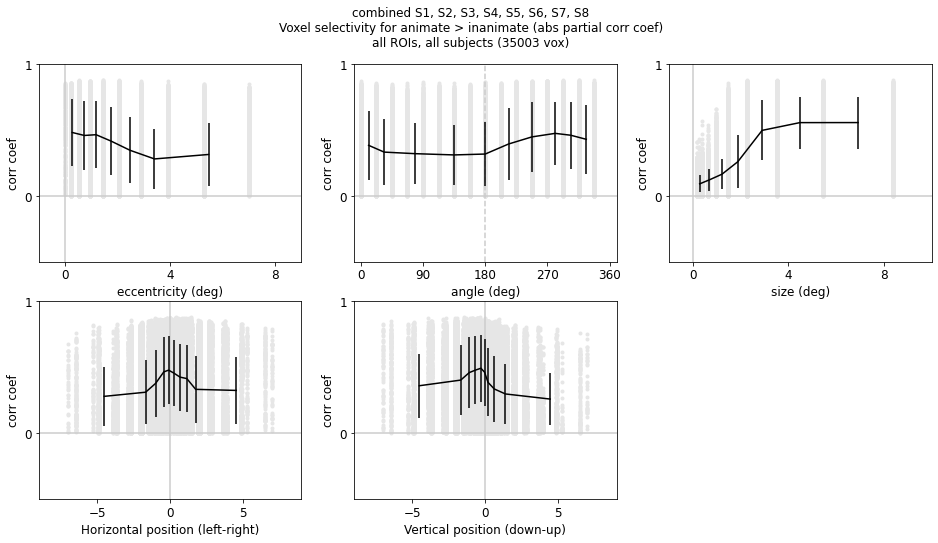

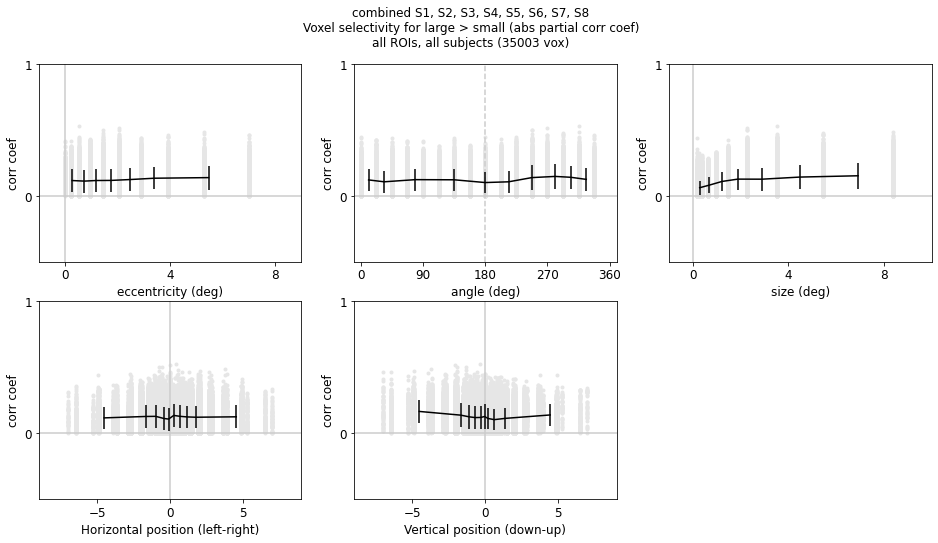

In [34]:

plot_utils.set_all_font_sizes(fs = 12)

dd2plot = [0,1,2];
# dd2plot = [0]

n_bins=10;
linear_bins=False

r2_cutoff = 0.10
val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)
inds2use = val_r2 > r2_cutoff

for dd in dd2plot:
    
    val2 = copy.deepcopy(np.abs(c_partial[:,dd]))
    name = partial_signed_names[dd]
    pi=0
    plt.figure(figsize=(16,8))
      
    for pp, pars in enumerate(parslist):
    
        val1 = pars
        
        pi+=1;
        plt.subplot(2,3,pi)

        x_vals=val1[inds2use];
        y_vals=val2[inds2use]

        ptcolor=np.array([[0.9, 0.9, 0.9]])
#         ptcolor=None
        plt.plot(x_vals,y_vals,'.',color=ptcolor)
        xbinned, ybinned, ystd = numpy_utils.bin_ydata_by_xdata(x_vals, y_vals, n_bins=n_bins, \
                                            linear_bins=linear_bins, return_std=True)    
        plt.errorbar(xbinned, ybinned, ystd, color='k',zorder=10)

        plt.xlim(parlims[pp])
        plt.ylim([-0.5,1])

        plt.axhline(0,color=[0.8, 0.8, 0.8])
        if 'angle' not in parnames[pp]:
            plt.axvline(0,color=[0.8, 0.8, 0.8])
        else:
            plt.axvline(180,color=[0.8, 0.8, 0.8],linestyle='--')

        plt.xlabel(parnames[pp])
        plt.ylabel('corr coef')
        plt.xticks(particks[pp])
        plt.yticks([0,1])
       
    plt.suptitle('%s\nVoxel selectivity for %s (abs partial corr coef)\nall ROIs, all subjects (%d vox)'\
                           %(summary_plots.get_substr(out), name, np.sum(inds2use)))


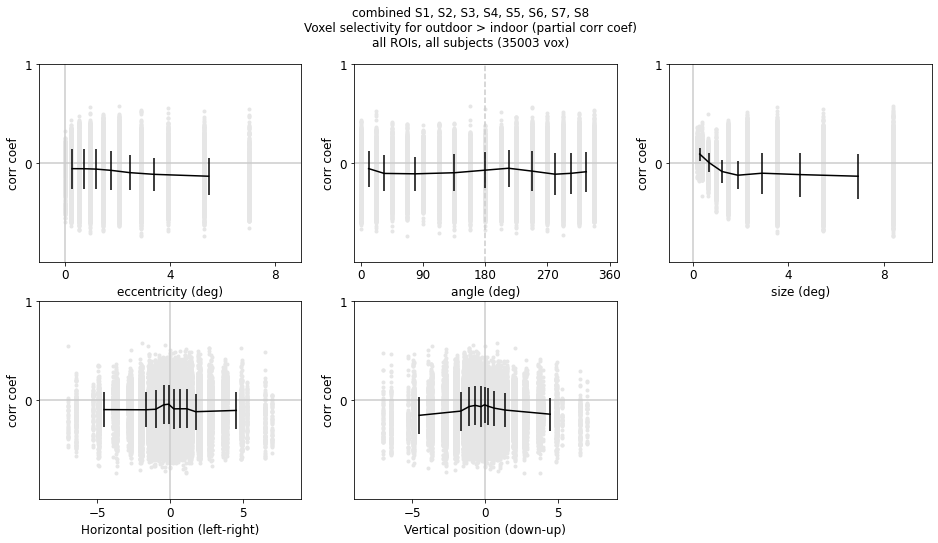

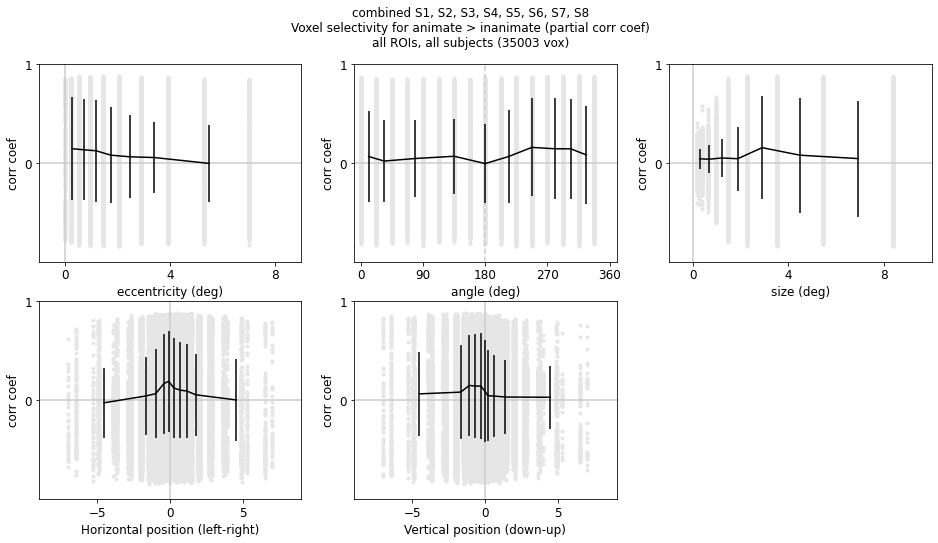

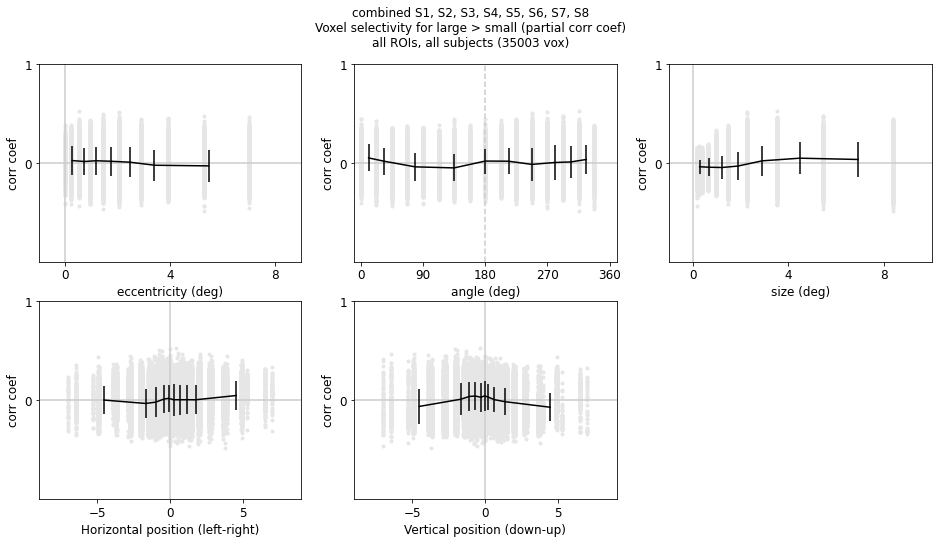

In [35]:

plot_utils.set_all_font_sizes(fs = 12)

dd2plot = [0,1,2];
# dd2plot = [0]

n_bins=10;
linear_bins=False

r2_cutoff = 0.10
val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)
inds2use = val_r2 > r2_cutoff

for dd in dd2plot:
    
    val2 = copy.deepcopy(c_partial[:,dd])

    name = partial_signed_names[dd]
    
    pi=0
    plt.figure(figsize=(16,8))
      
    for pp, pars in enumerate(parslist):
    
        val1 = pars
        
        pi+=1;
        plt.subplot(2,3,pi)

        x_vals=val1[inds2use];
        y_vals=val2[inds2use]

        ptcolor=np.array([[0.9, 0.9, 0.9]])
#         ptcolor=None
        plt.plot(x_vals,y_vals,'.',color=ptcolor)
        xbinned, ybinned, ystd = numpy_utils.bin_ydata_by_xdata(x_vals, y_vals, n_bins=n_bins, \
                                            linear_bins=linear_bins, return_std=True)    
        plt.errorbar(xbinned, ybinned, ystd, color='k',zorder=10)

        plt.xlim(parlims[pp])
        plt.ylim([-1,1])

        plt.axhline(0,color=[0.8, 0.8, 0.8])
        if 'angle' not in parnames[pp]:
            plt.axvline(0,color=[0.8, 0.8, 0.8])
        else:
            plt.axvline(180,color=[0.8, 0.8, 0.8],linestyle='--')

        plt.xlabel(parnames[pp])
        plt.ylabel('corr coef')
        plt.xticks(particks[pp])
        plt.yticks([0,1])
       
    plt.suptitle('%s\nVoxel selectivity for %s (partial corr coef)\nall ROIs, all subjects (%d vox)'\
                           %(summary_plots.get_substr(out), name, np.sum(inds2use)))


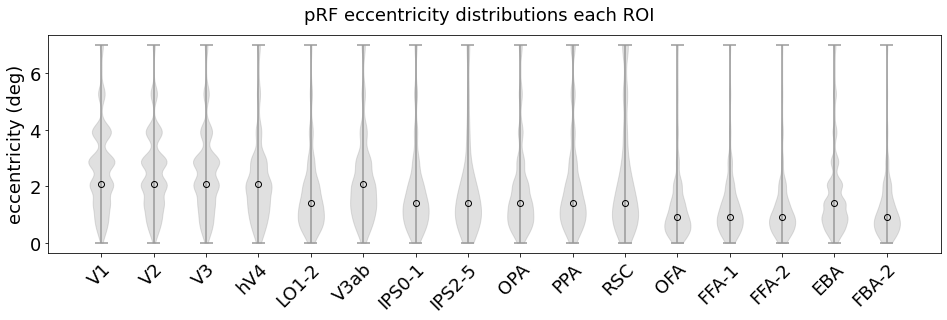

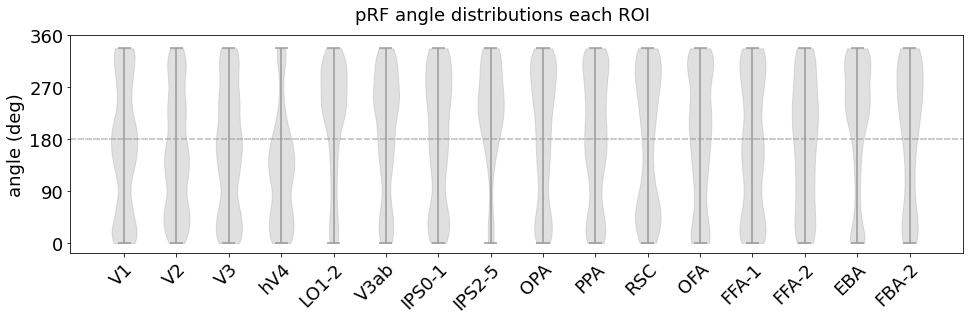

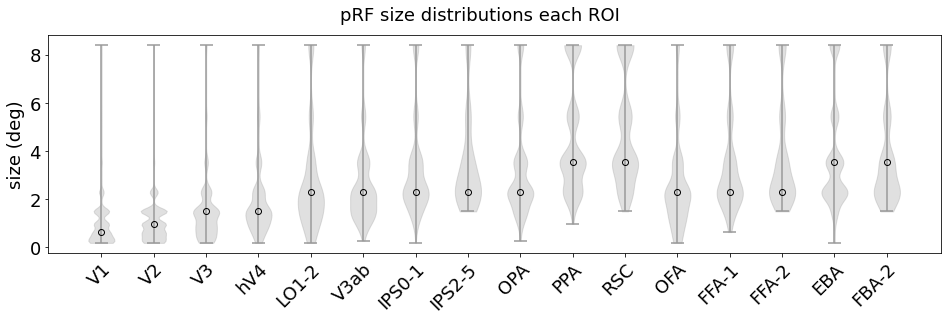

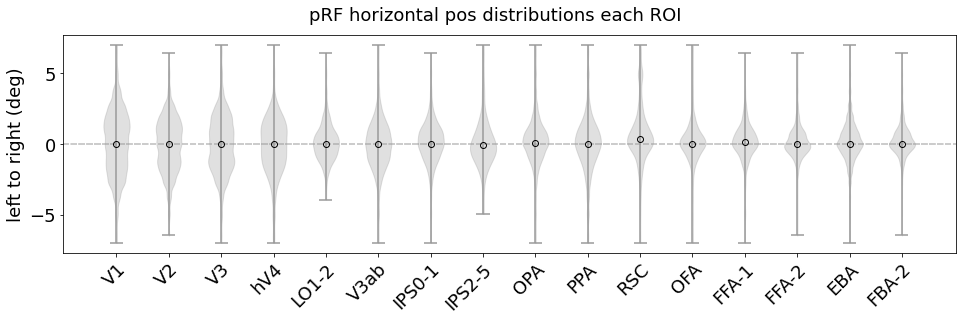

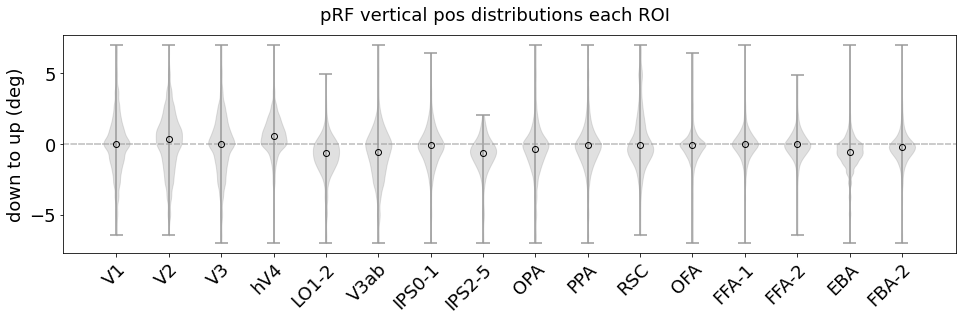

In [183]:

plot_utils.set_all_font_sizes(18)

r2_cutoff = 0.10
val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)
abv_thresh = val_r2>r2_cutoff

npx = int(np.ceil(np.sqrt(n_rois)))
npy = int(np.ceil(n_rois/npx))

parslist = [voxel_ecc, voxel_angle, voxel_size, voxel_xcoord, voxel_ycoord]
parnames = ['eccentricity', 'angle', 'size', 'horizontal pos', 'vertical pos']
axnames = ['eccentricity (deg)', 'angle (deg)', 'size (deg)', 'left to right (deg)', 'down to up (deg)']

color = [0.6, 0.6, 0.6]

for pp, pars in enumerate(parslist):
   
    pi=0
    plt.figure(figsize=(16,4))

    for rr in range(n_rois):

        inds_this_roi = roi_def.get_indices(rr) & abv_thresh

        parts = plt.violinplot(pars[inds_this_roi],[rr])
        for pc in parts['bodies']:
            pc.set_color(color)
        parts['cbars'].set_color(color)
        parts['cmins'].set_color(color)
        parts['cmaxes'].set_color(color)
        
        if parnames[pp]=='angle':
            plt.yticks([0,90,180,270,360])
            plt.axhline(180,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)
            
        else:
            plt.plot(rr, np.median(pars[inds_this_roi]), 'o',\
                     markeredgecolor='k',markerfacecolor='none')

        plt.ylabel(axnames[pp])

        if 'pos' in parnames[pp]:
            plt.axhline(0,linestyle='--',color=[0.8, 0.8, 0.8],zorder=-10)
            
    plt.xticks(ticks=np.arange(0,n_rois),labels=roi_names,\
                           rotation=45, ha='right',rotation_mode='anchor')
           
    plt.suptitle('pRF %s distributions each ROI'%parnames[pp])


In [48]:
size_cutoff

1.219999998807907

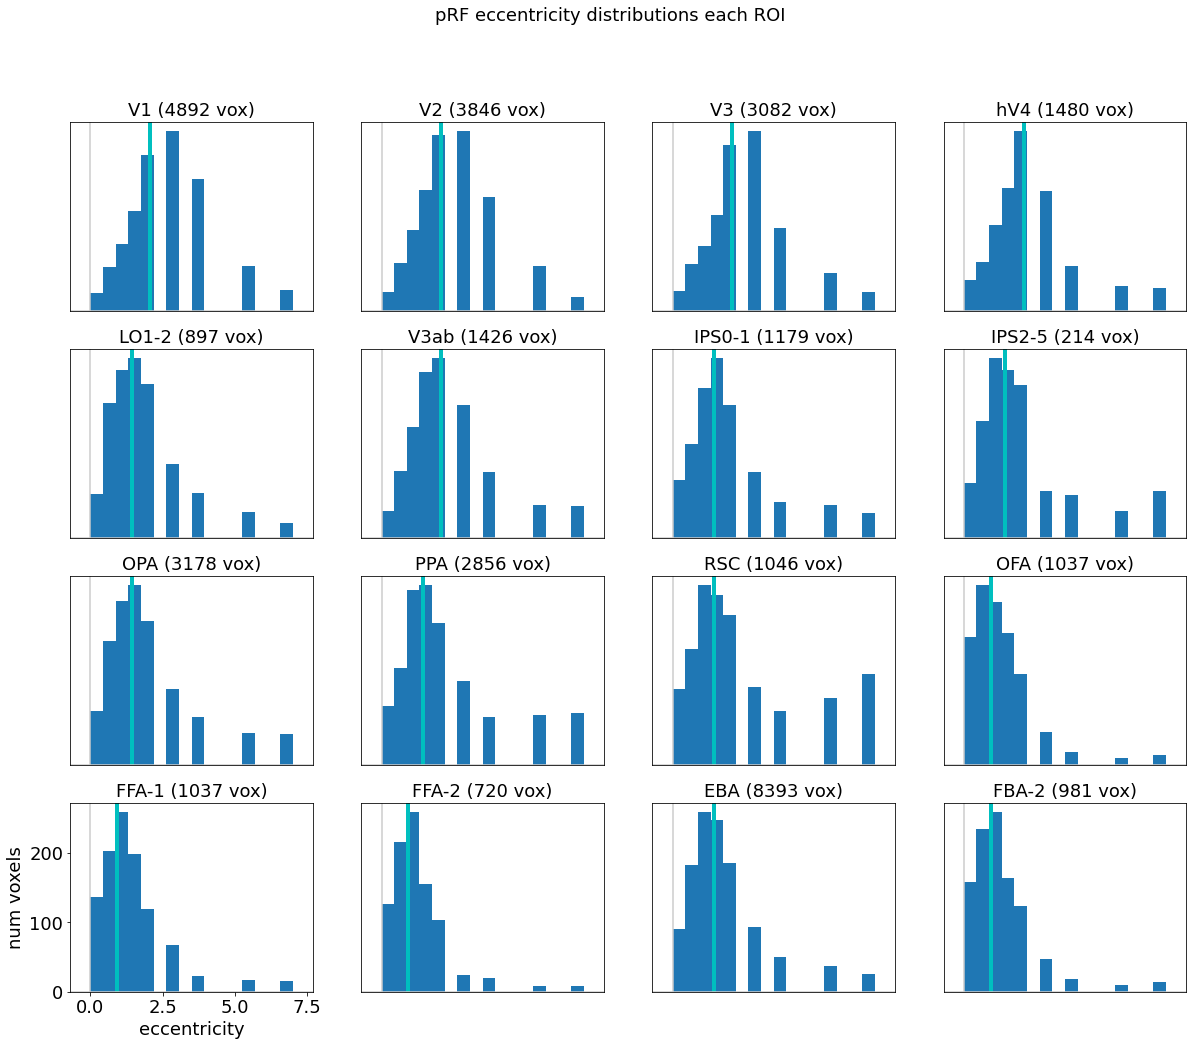

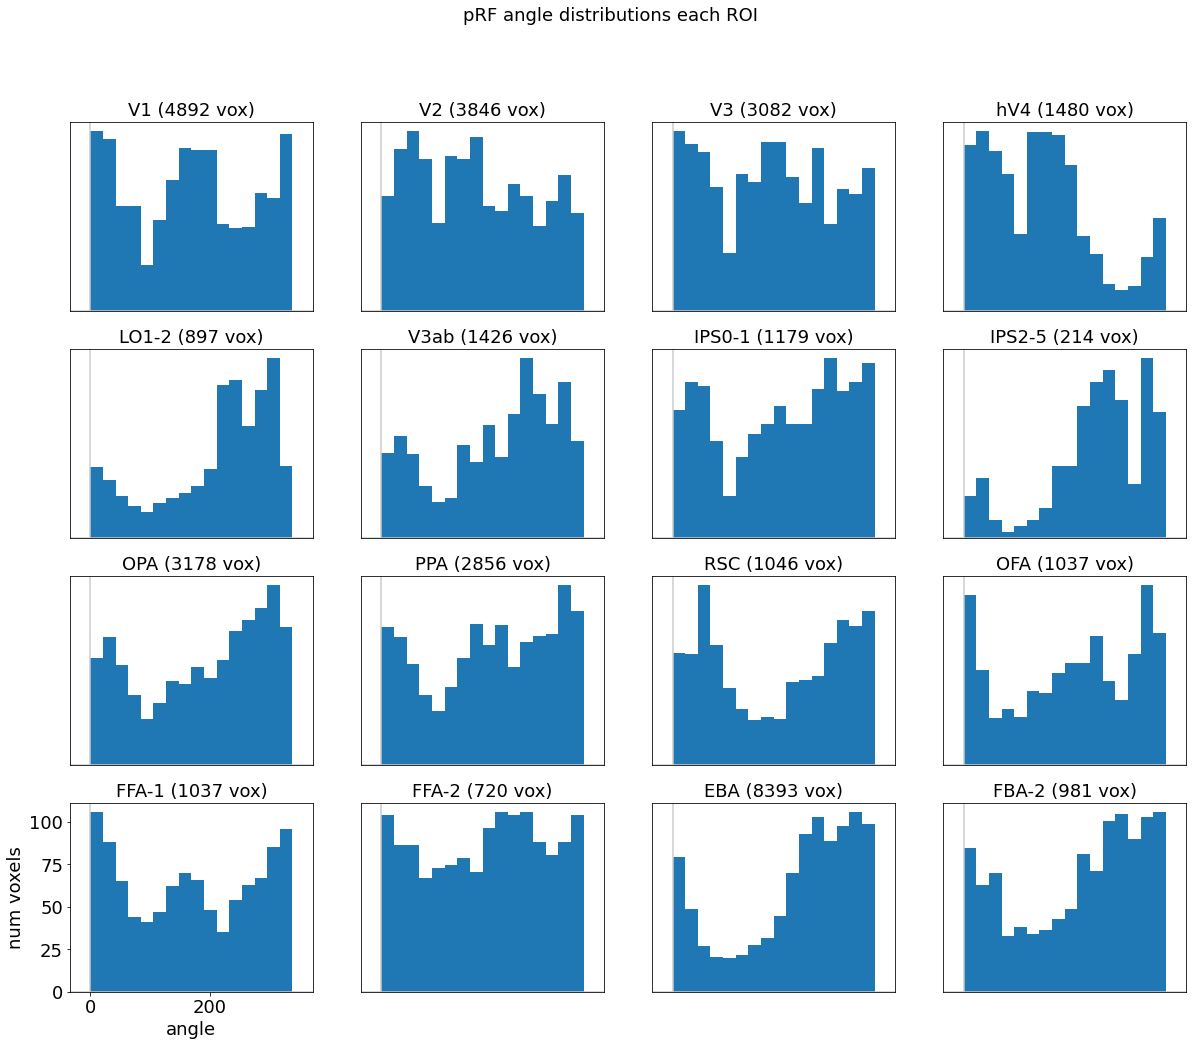

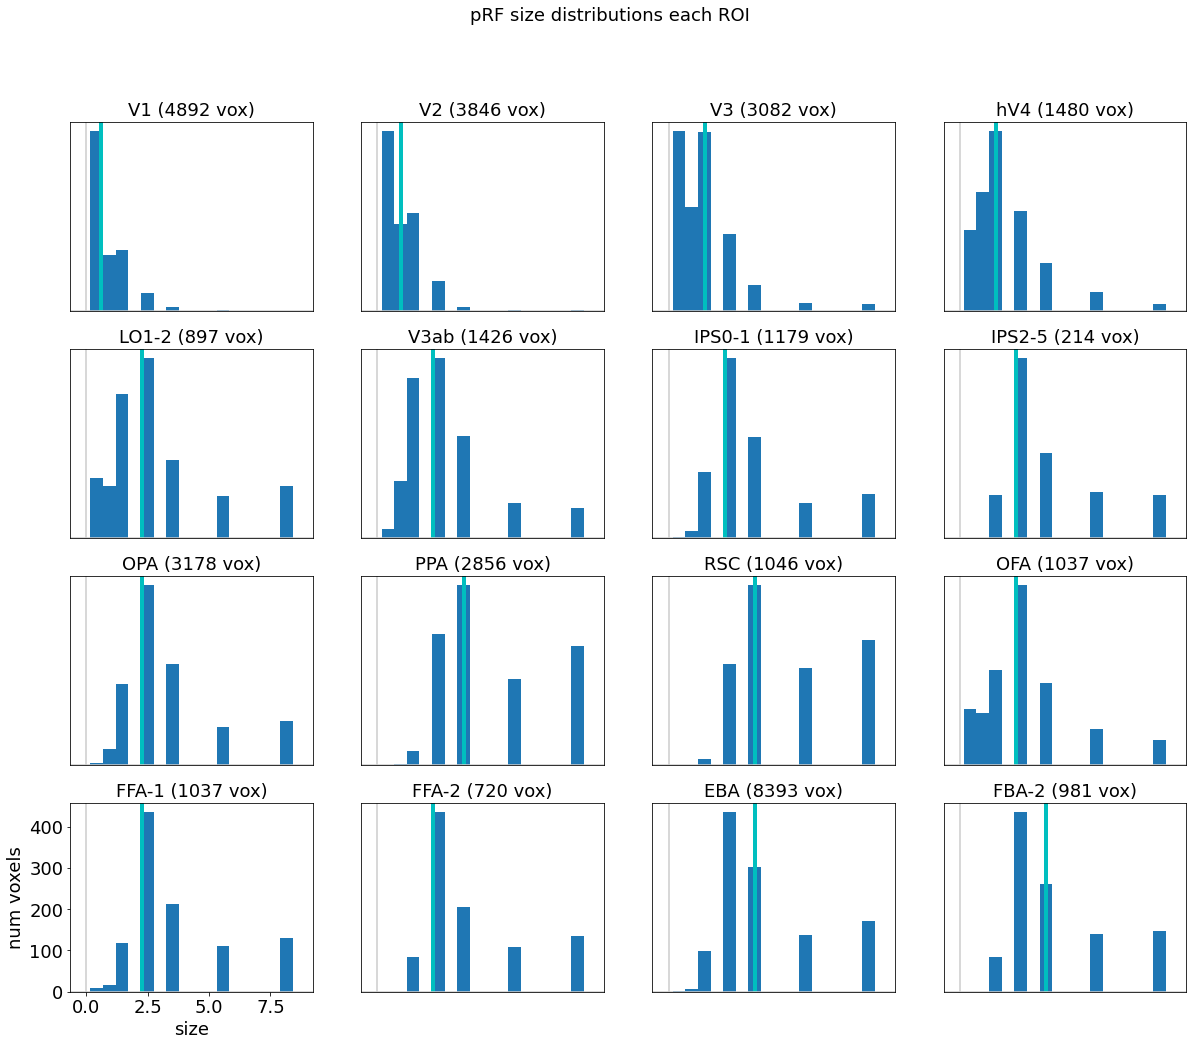

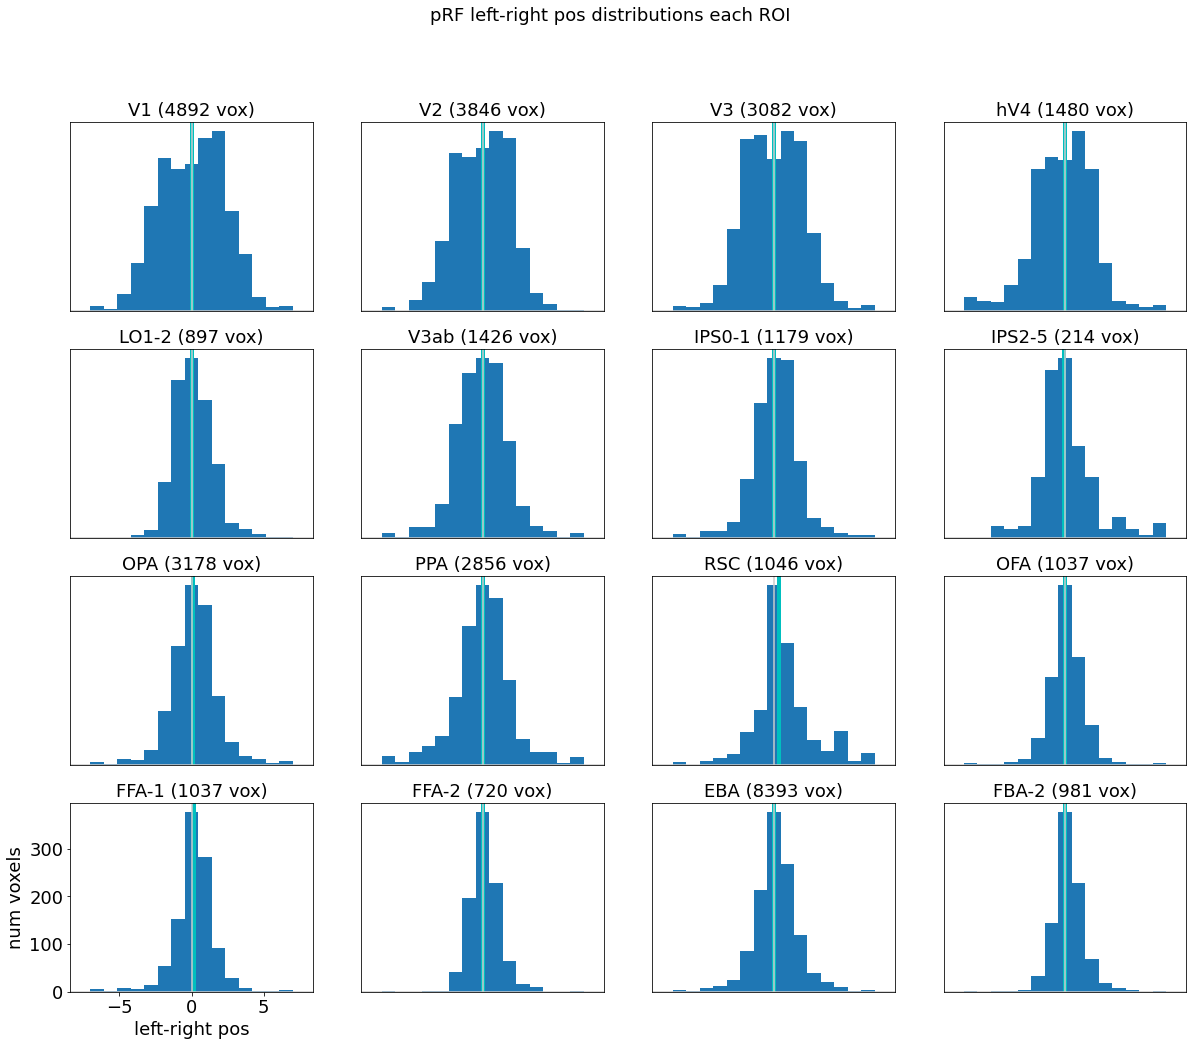

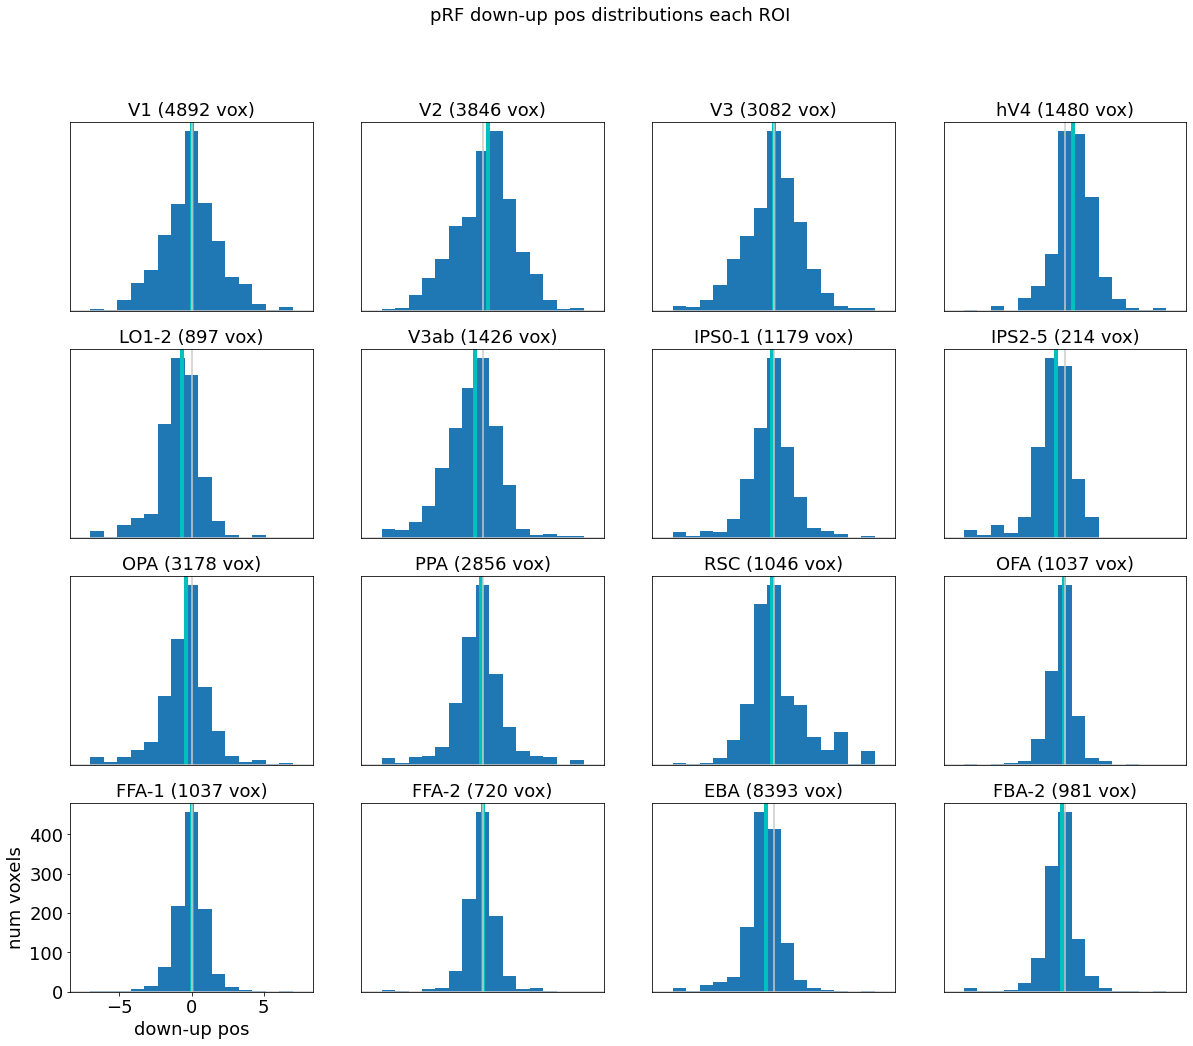

In [58]:

plot_utils.set_all_font_sizes(18)

r2_cutoff = 0.10
val_r2 = np.concatenate([out[si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)
abv_thresh = val_r2>r2_cutoff

npx = int(np.ceil(np.sqrt(n_rois)))
npy = int(np.ceil(n_rois/npx))

parslist = [voxel_ecc, voxel_angle, voxel_size, voxel_xcoord, voxel_ycoord]
parnames = ['eccentricity', 'angle', 'size', 'left-right pos', 'down-up pos']
# nbins = [len(np.unique(par)) for par in parslist]
nbins = [16,16,16,15,15]
bins = [np.linspace(np.min(par)-0.0001, np.max(par)+0.0001, nb+1) \
        for par, nb in zip(parslist, nbins)]
lims = [[np.min(par)-(np.max(par)-np.min(par))*0.10, \
         np.max(par)+(np.max(par)-np.min(par))*0.10] \
            for par in parslist]
unvals = [np.unique(pars) for pars in parslist]
bw = [un[1]-un[0] for un in unvals]

for pp, pars in enumerate(parslist):
   
    pi=0
    plt.figure(figsize=(20,16))

    for rr in range(n_rois):

        inds_this_roi = roi_def.get_indices(rr) & abv_thresh

        pi+=1
        plt.subplot(npx,npy,pi)

        h = plt.hist(pars[inds_this_roi], bins[pp])
#         counts = [np.sum(pars[inds_this_roi]==un) for un in unvals[pp]]
#         assert(np.sum(counts)==np.sum(inds_this_roi))
#         plt.bar(unvals[pp], counts, bw[pp])
        if not parnames[pp]=='angle':
            plt.axvline(np.median(pars[inds_this_roi]), color='c', linewidth=4)
        
        plt.axhline(0,color=[0.8, 0.8, 0.8])
        plt.axvline(0,color=[0.8, 0.8, 0.8])
        plt.title('%s (%d vox)'%(roi_names[rr], np.sum(inds_this_roi)))

        if pi==(n_rois-3):
            plt.xlabel(parnames[pp])
            plt.ylabel('num voxels')
        else:
            plt.xticks([])
            plt.yticks([])
        plt.xlim(lims[pp])
           
    plt.suptitle('pRF %s distributions each ROI'%parnames[pp])
